# Results 

In [41]:
import numpy as np
import dill
from Optimizer_Scripts.functions import ackley_gen, rastrigin_gen, ackley_deriv_gen, rast_deriv_gen
from Optimizer_Scripts.optimizers import Adam, Momentum, NesterovMomentum
from Optimizer_Scripts.Delayer import Delayer
import os
import re
import matplotlib.pyplot as plt

In [42]:
maxiter=5000
tol=1e-5

In [43]:
del_dir_const = '../results/del_True/lr_True'
del_dir_nonconst = '../results/del_True/lr_False'
un_dir_const = '../results/del_False/lr_True'
un_dir_nonconst = '../results/del_False/lr_False'
#the list of symmetric delayed
rast_del_sym = list()
ack_del_sym = list()
#the list of unsymmetric delayed
rast_del_unsym = list()
ack_del_unsym = list()
#list of delayed nonconstant learning rate symmetric
rast_del_lr_sym = list()
ack_del_lr_sym = list()
#list of delayed nonconstant learning rate nonsymmetric
rast_del_lr_nonsym = list()
ack_del_lr_nonsym = list()
#list of delayed nonconstant learning rate early stopping symmetric
rast_del_lr_sym_stop = list()
ack_del_lr_sym_stop = list()
#list of delayed nonconstant learning rate early stopping nonsymmetric
rast_del_lr_nonsym_stop = list()
ack_del_lr_nonsym_stop = list()

#the list of undelayd
rast_undel = list()
ack_undel = list()
#the list of undelayed nonconstant learning rate
rast_undel_lr = list()
ack_undel_lr = list()
#list of undelayed nonconstant learning rate early stopping
rast_undel_lr_stop = list()
ack_undel_lr_stop = list()

In [44]:
#get the delayed constant learning rate tests
for filename in os.listdir(del_dir_const):
    delay_object = dill.load( open(del_dir_const+"/"+filename, "rb" ) ) 
    if re.match(r"^test_symTrue_.*_Rastrigin", filename):
        rast_del_sym.append(delay_object)
    elif re.match(r"^test_symTrue_.*_Ackley", filename):
        ack_del_sym.append(delay_object)
    elif re.match(r"^test_symFalse_.*_Rastrigin", filename):
        rast_del_unsym.append(delay_object)
    elif re.match(r"^test_symFalse.*_Ackley", filename):
        ack_del_unsym.append(delay_object)
    else:
        print("file did not match")
        print(filename)
        
#get the delayed non constant learning rate tests        
for filename in os.listdir(del_dir_nonconst):
    delay_object = dill.load(open(del_dir_nonconst+"/"+filename, "rb"))
    if re.match(r"^test_symTrue_.*Rastrigin.*_stop_True", filename):
        rast_del_lr_sym_stop.append(delay_object)
    elif re.match(r"^test_symFalse_.*Rastrigin.*_stop_True", filename):
        rast_del_lr_nonsym_stop.append(delay_object)
    if re.match(r"^test_symTrue_.*Ackley.*_stop_True", filename):
        ack_del_lr_sym_stop.append(delay_object)
    elif re.match(r"^test_symFalse_.*Ackley.*_stop_True", filename):
        ack_del_lr_nonsym_stop.append(delay_object)
    elif re.match(r"^test_symTrue_.*_Ackley", filename):
        ack_del_lr_sym.append(delay_object)
    elif re.match(r"^test_symFalse_.*_Ackley", filename):
        ack_del_lr_nonsym.append(delay_object)
    elif re.match(r"^test_symTrue_.*_Rastrigin", filename):
        rast_del_lr_sym.append(delay_object)
    elif re.match(r"^test_symFalse_.*_Rastrigin", filename):
        rast_del_lr_nonsym.append(delay_object)
    else:
        print("file did not match")
        print(filename)

In [45]:
#get the undelayed constant learning rate tests
for filename in os.listdir(un_dir_const):
    delay_object = dill.load( open(un_dir_const+"/"+filename, "rb" ) )
    if re.match(r"^test_.*_Ackley", filename):
        ack_undel.append(delay_object)
    elif re.match(r"^test_.*_Rastrigin", filename):
        rast_undel.append(delay_object)
    else:
        print("file did not match") 
        print(filename)
        
#get the undelayed nonconstant learning rate tests
for filename in os.listdir(un_dir_nonconst):
    delay_object = dill.load( open(un_dir_nonconst+"/"+filename, "rb" ) )
    if re.match(r"^test_.*_Ackley.*_stop_True", filename):
        ack_undel_lr_stop.append(delay_object)
    elif re.match(r"^test_.*_Rastrigin.*_stop_True", filename):
        rast_undel_lr_stop.append(delay_object)
    if re.match(r"^test_.*_Ackley", filename):
        ack_undel_lr.append(delay_object)
    elif re.match(r"^test_.*_Rastrigin", filename):
        rast_undel_lr.append(delay_object)
    else:
        print("file did not match") 
        print(filename)

In [6]:
#generate learning rates
def gen_learning_rates(params,maxiter):
    learning_rates = np.zeros(maxiter)
    max_alpha = params['max_learning_rate']
    min_alpha = params['min_learning_rate']
    step_size = params['step_size']
    num_changes = maxiter // (2*step_size)
    current_max = max_alpha
    step_int = (current_max - min_alpha) / step_size
    it_num = 0
    while (it_num < maxiter):
        if (it_num == 0):
            learning_rates[it_num] = min_alpha
        else:
            learning_rates[it_num] = learning_rates[it_num-1] + step_int
        it_num += 1
        #check to update parameters for learning rate updates
        if (it_num % step_size == 0):
            if (it_num % (step_size*2) == 0):           
                curent_max = current_max/2
                step_int = (current_max - min_alpha) / step_size
            else:
                step_int = -1*step_int 
    return learning_rates
    

#helper function for analyzing results of a specific list
def analyzer(list_to_analyze, dom_range, num_tests=10, use_delays=True, symmetric_delays=True, early_stopping=False, constant_learning_rate=True, Title="Not Defined!", maxiter=5000, tol=1e-5, dim=10):
    for i in list_to_analyze:
        if (i.n == dim):
            print(i.Optimizer.learning_rate_bounds)
            if (constant_learning_rate is True):
                i.Optimizer.params['learning_rate'] = i.Optimizer.learning_rate_bounds * np.ones(maxiter)
            else:
                i.Optimizer.params['learning_rate'] = gen_learning_rates(i.Optimizer.learning_rate_bounds, maxiter)
            plt.clf()
            list_mins = list()
            list_argmins = list()
            for j in range(num_tests):
                i.x_init = np.random.uniform(dom_range[0],dom_range[1],i.n)
                i.delete_time_series()
                i.compute_time_series(use_delays=use_delays, maxiter=maxiter, tol=tol, symmetric_delays=symmetric_delays, random=True)
                x_vals = list()
                for k in range(len(i.time_series)):
                    x_vals.append(i.loss_function(i.time_series[k,:]))
                i.delete_time_series()
                ys = np.arange(0, len(x_vals), 1)
                plt.plot(ys, x_vals, 'r', alpha=0.2)
                if (early_stopping is True):
                    list_mins.append(np.min(x_vals))
                    argmin = np.argmin(x_vals)
                    list_argmins.append(argmin)
                    ys = np.arange(0, argmin+1, 1)
                    plt.plot(ys, x_vals[:argmin+1], 'r', alpha=0.2)
                else:
                    ys = np.arange(0, len(x_vals), 1)
                    plt.plot(ys, x_vals, 'r', alpha=0.2)
            if (early_stopping is True):  
                mean_min = np.mean(list_mins)
                plt.plot(list_argmins, list_mins, 'og', label = "{}".format(mean_min))
                plt.legend(loc="center right")
            plt.title(Title+" n={}".format(i.n))
            plt.show()

## Ackley Function Learning Rate Optimization

## The ackley tests

### 10 Dimensional ackley tests

###### Symmetric Results

1.4903897705143623


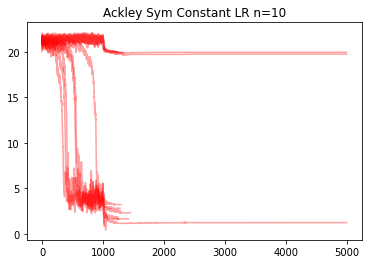

1.3739717461559058


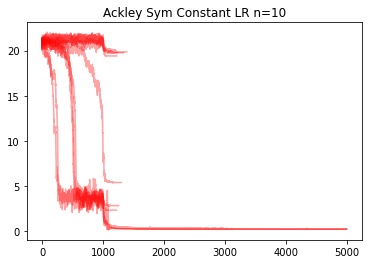

1.1877937970913375


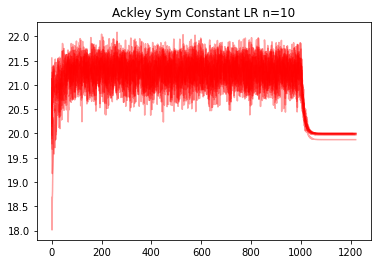

1.3951289769091597


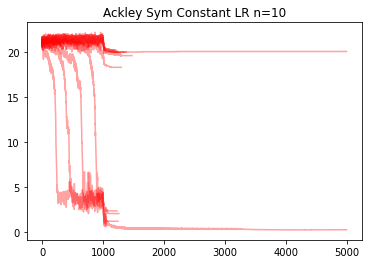

0.3201712297319476


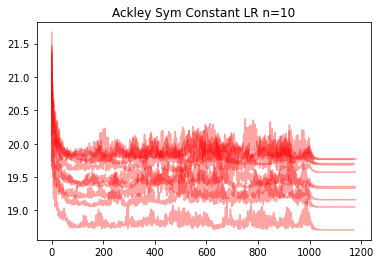

0.5686703492228172


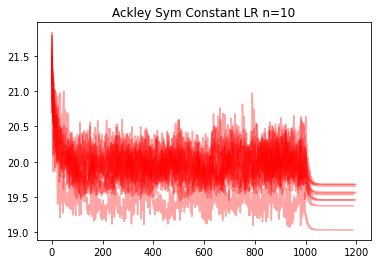

0.7956103659414648


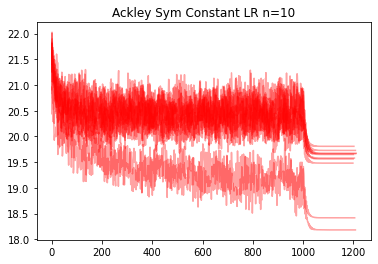

0.4105376460722983


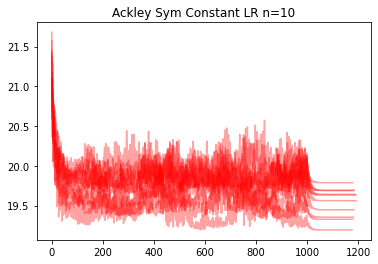

1.3777413790030018


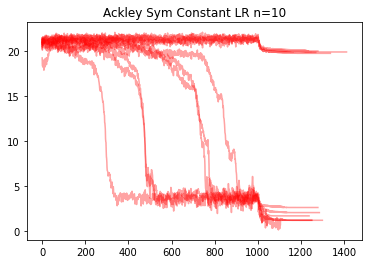

0.6491135827547679


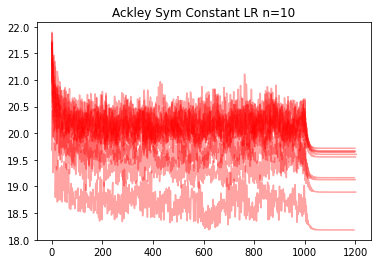

{'max_learning_rate': 2.1542838504315056, 'min_learning_rate': 0.1308503943321732, 'step_size': 810}


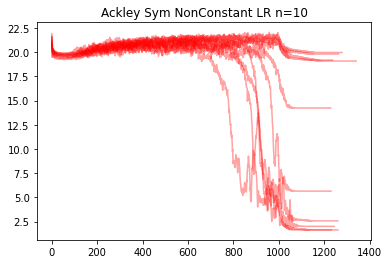

{'max_learning_rate': 2.4514723284245856, 'min_learning_rate': 0.4040019559848742, 'step_size': 550}


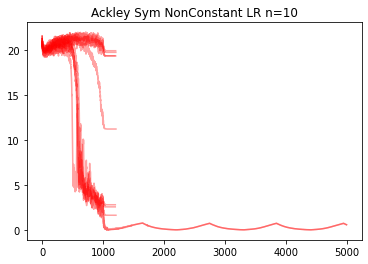

{'max_learning_rate': 1.5679713500708643, 'min_learning_rate': 0.9335467181023808, 'step_size': 1250}


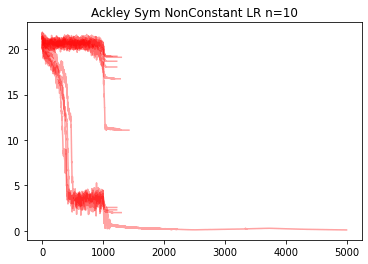

{'max_learning_rate': 3.6863801074977927, 'min_learning_rate': 0.13981935502301152, 'step_size': 1360}


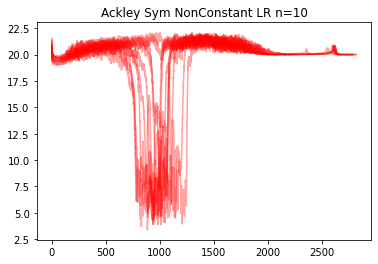

{'max_learning_rate': 2.0021740906332344, 'min_learning_rate': 0.7497766479744385, 'step_size': 1900}


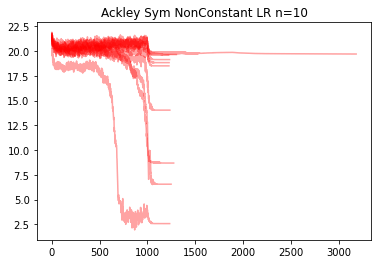

{'max_learning_rate': 1.3179251238701462, 'min_learning_rate': 0.27426985762915046, 'step_size': 100}


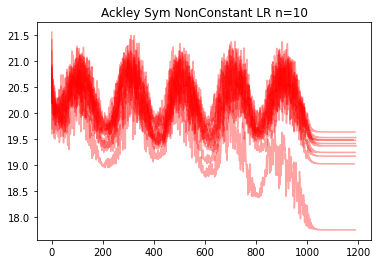

{'max_learning_rate': 1.239678694029807, 'min_learning_rate': 0.9334292043395854, 'step_size': 1810}


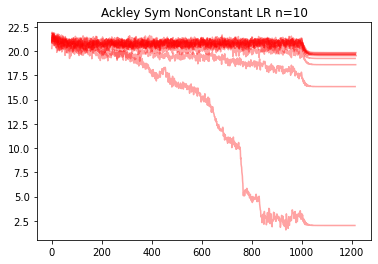

{'max_learning_rate': 2.5943257307158567, 'min_learning_rate': 0.8595331627981595, 'step_size': 1680}


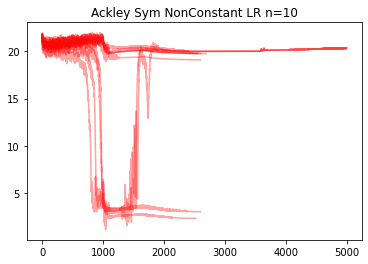

{'max_learning_rate': 3.4603802430271813, 'min_learning_rate': 0.4768392097473546, 'step_size': 1740}


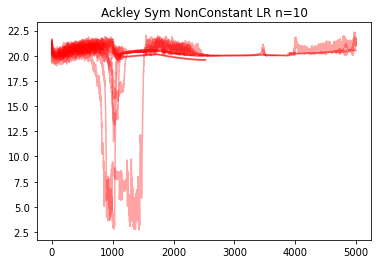

{'max_learning_rate': 3.655922974400597, 'min_learning_rate': 0.19429019684520854, 'step_size': 1290}


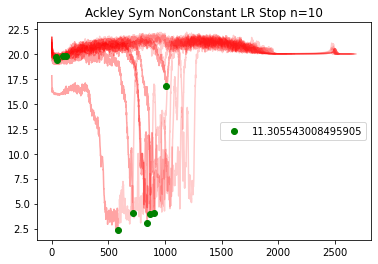

{'max_learning_rate': 1.3363383036663308, 'min_learning_rate': 0.4881311762276738, 'step_size': 60}


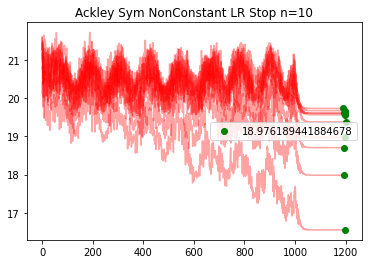

{'max_learning_rate': 3.2162025294749994, 'min_learning_rate': 0.6508170017004999, 'step_size': 2270}


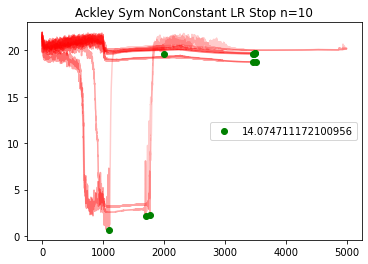

{'max_learning_rate': 2.135504351217956, 'min_learning_rate': 0.38201660941858423, 'step_size': 1220}


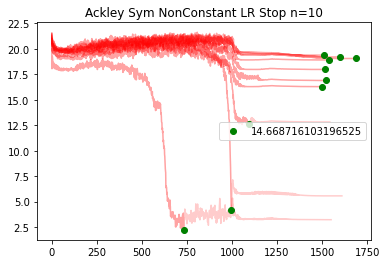

{'max_learning_rate': 3.5769156285760793, 'min_learning_rate': 0.9016145107709228, 'step_size': 1370}


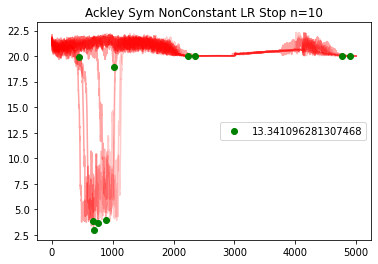

{'max_learning_rate': 2.2222500829786913, 'min_learning_rate': 0.8155863933236849, 'step_size': 940}


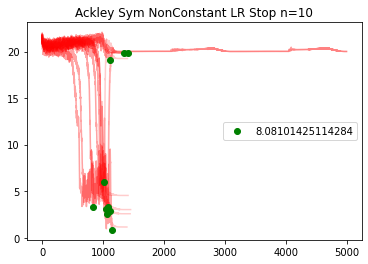

{'max_learning_rate': 3.334581068493826, 'min_learning_rate': 0.8791179323669955, 'step_size': 750}


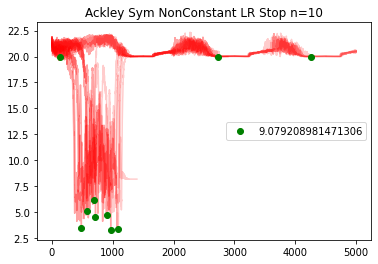

In [7]:
#symmetric with constant learning rate
analyzer(ack_del_sym, dom_range=[-32., 32.], Title="Ackley Sym Constant LR", constant_learning_rate=True, symmetric_delays=True, dim=10)
#symmetric nonconstant learning rate
analyzer(ack_del_lr_sym, dom_range=[-32., 32.], Title="Ackley Sym NonConstant LR", constant_learning_rate=False, symmetric_delays=True, num_tests=10, dim=10)
#symmertic non constant learning rate with early stopping 
analyzer(ack_del_lr_sym_stop, dom_range=[-32.,32.], Title="Ackley Sym NonConstant LR Stop", constant_learning_rate=False, symmetric_delays=True, num_tests=10, dim=10, early_stopping=True)

#### Nonsymmetric Results

0.2809010442292468


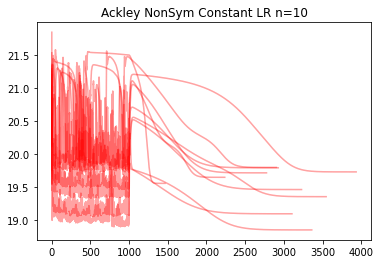

0.9877172782228976


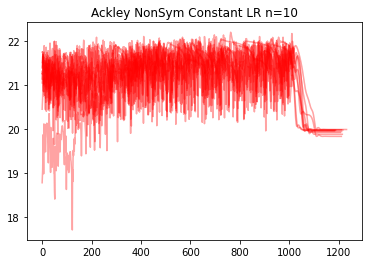

0.0004372512071800505


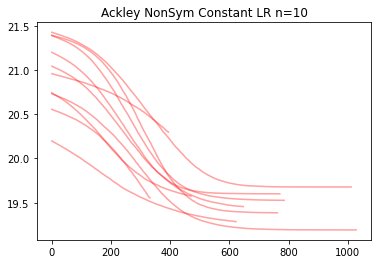

0.24745031626690614


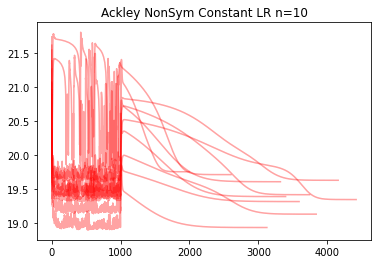

0.943473519728147


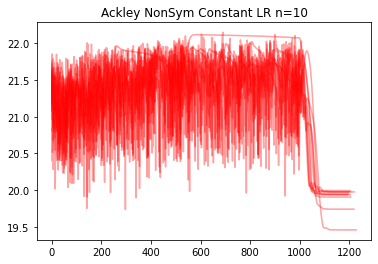

0.6802416978551913


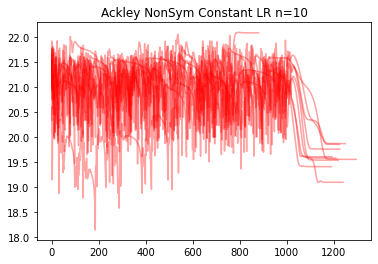

0.22969114296580823


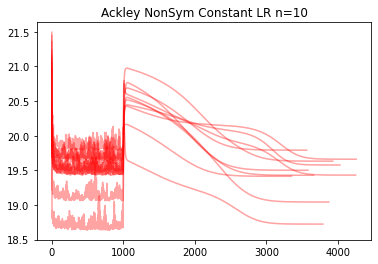

0.2860296464716244


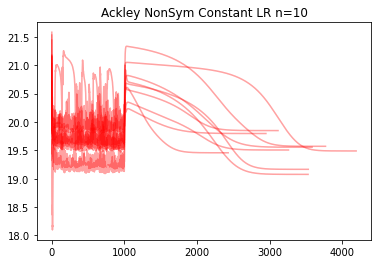

0.44463155851406794


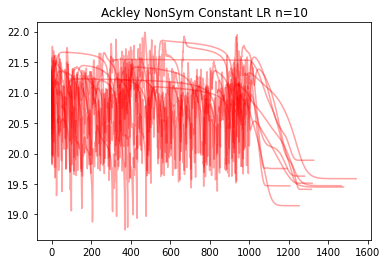

0.3434428799230742


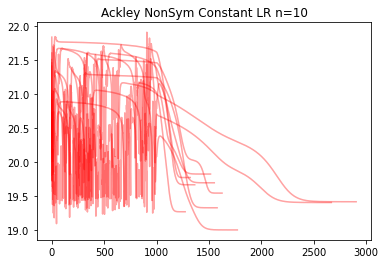

{'max_learning_rate': 1.6638360033233228, 'min_learning_rate': 0.3934261633628238, 'step_size': 1760}


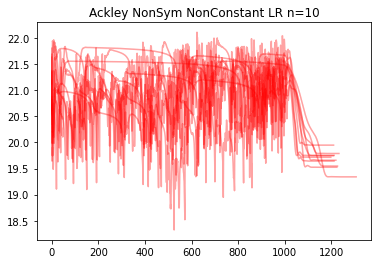

{'max_learning_rate': 3.8629958737667724, 'min_learning_rate': 0.5092313644807007, 'step_size': 550}


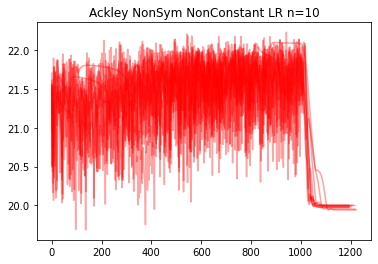

{'max_learning_rate': 2.769722511722531, 'min_learning_rate': 0.42252265237861364, 'step_size': 2160}


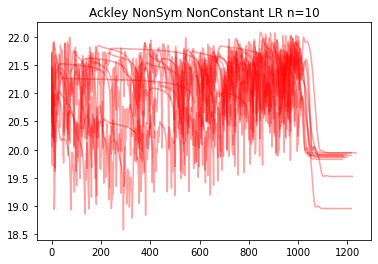

{'max_learning_rate': 3.223815000050883, 'min_learning_rate': 0.17379226466539116, 'step_size': 300}


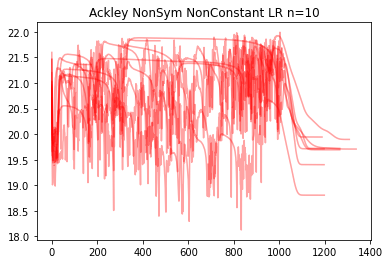

{'max_learning_rate': 1.847130716520324, 'min_learning_rate': 0.9822762839847528, 'step_size': 2130}


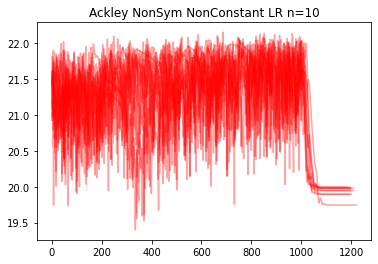

{'max_learning_rate': 1.7009739050508061, 'min_learning_rate': 0.821543889353341, 'step_size': 130}


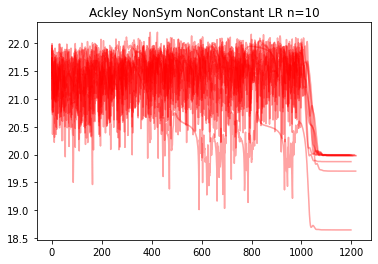

{'max_learning_rate': 1.437168918046567, 'min_learning_rate': 0.290442991692353, 'step_size': 2200}


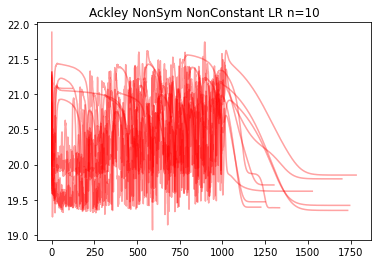

{'max_learning_rate': 1.7091928800020273, 'min_learning_rate': 0.3137430545658315, 'step_size': 1380}


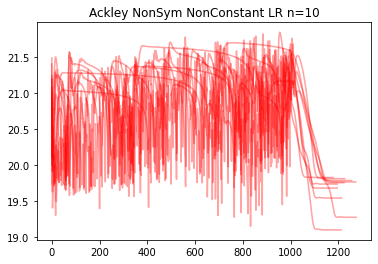

{'max_learning_rate': 2.2728718792425546, 'min_learning_rate': 0.9624653296857517, 'step_size': 1300}


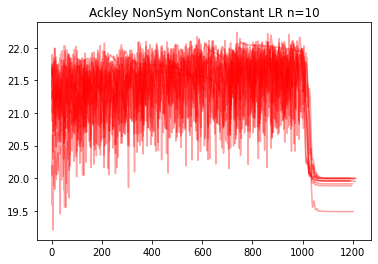

{'max_learning_rate': 2.0513410763546087, 'min_learning_rate': 0.5180623763768937, 'step_size': 700}


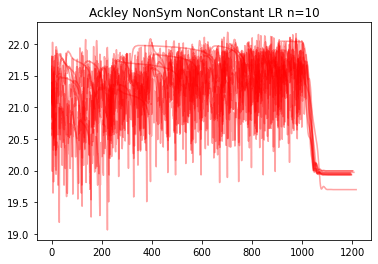

{'max_learning_rate': 1.3245286120170428, 'min_learning_rate': 0.4812139332495304, 'step_size': 1570}


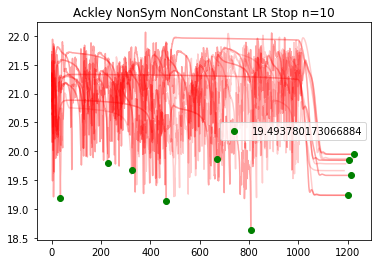

{'max_learning_rate': 2.420522975949234, 'min_learning_rate': 0.4644277649594766, 'step_size': 250}


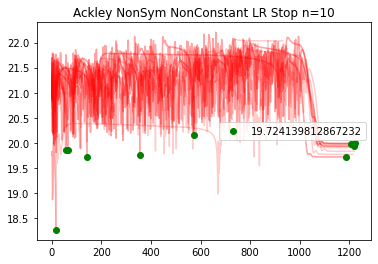

{'max_learning_rate': 3.9364652275461935, 'min_learning_rate': 0.4971590690118856, 'step_size': 1790}


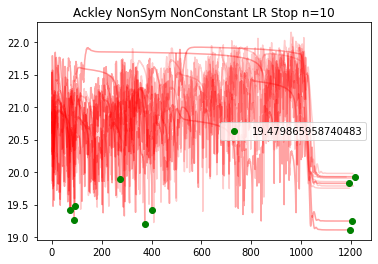

{'max_learning_rate': 3.7651733968350642, 'min_learning_rate': 0.3803061094649661, 'step_size': 2410}


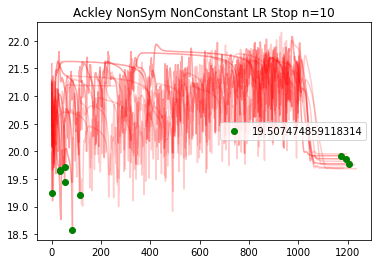

{'max_learning_rate': 4.301916496586448, 'min_learning_rate': 0.7271641343571652, 'step_size': 740}


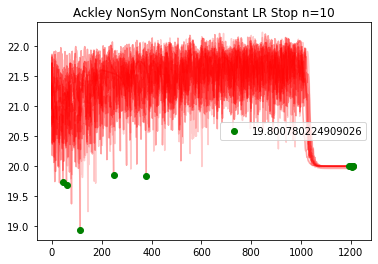

{'max_learning_rate': 3.3743247873340145, 'min_learning_rate': 0.3069551954043021, 'step_size': 1720}


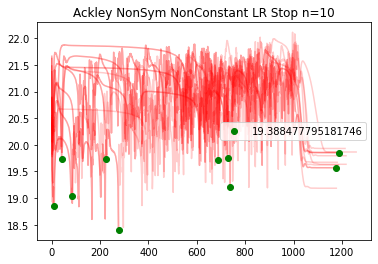

{'max_learning_rate': 1.321011625421289, 'min_learning_rate': 0.8123341594851692, 'step_size': 70}


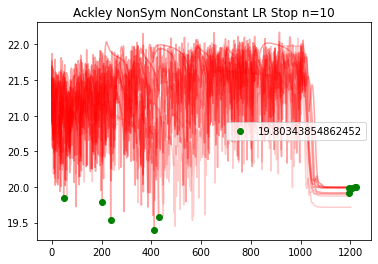

{'max_learning_rate': 4.083391913298139, 'min_learning_rate': 0.35385607201859626, 'step_size': 200}


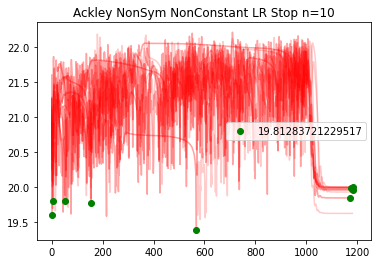

{'max_learning_rate': 4.714237017500185, 'min_learning_rate': 0.424083475056012, 'step_size': 2430}


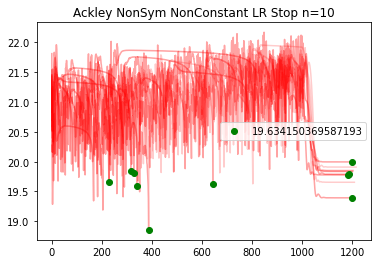

{'max_learning_rate': 2.7663074433337087, 'min_learning_rate': 0.5308084153452665, 'step_size': 350}


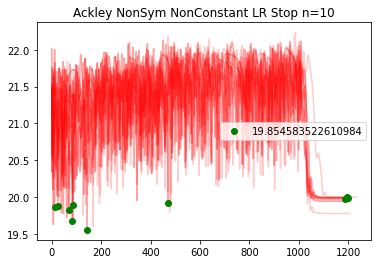

In [8]:
#symmetric with constant learning rate
analyzer(ack_del_unsym, dom_range=[-32., 32.], Title="Ackley NonSym Constant LR", symmetric_delays=False, constant_learning_rate=True, dim=10)
#symmetric nonconstant learning rate
analyzer(ack_del_lr_nonsym, dom_range=[-32., 32.], Title="Ackley NonSym NonConstant LR", symmetric_delays=False, constant_learning_rate=False, num_tests=10, dim=10)
#symmertic non constant learning rate with early stopping 
analyzer(ack_del_lr_nonsym_stop, dom_range=[-32.,32.], Title="Ackley NonSym NonConstant LR Stop", symmetric_delays=False, constant_learning_rate=False, num_tests=10, dim=10, early_stopping=True)

#### Undelayed Results

0.0005593368274511676


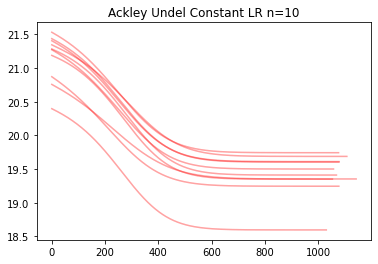

1.4486460529477432


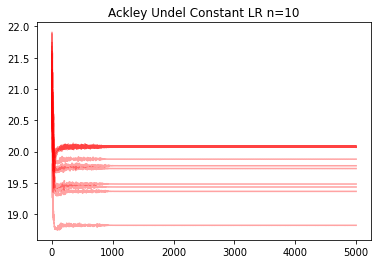

1.1255062301618892


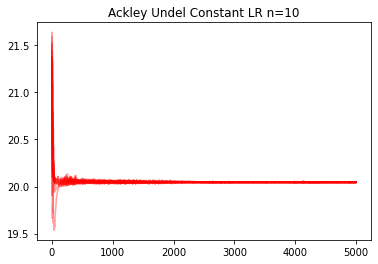

0.16914459222047654


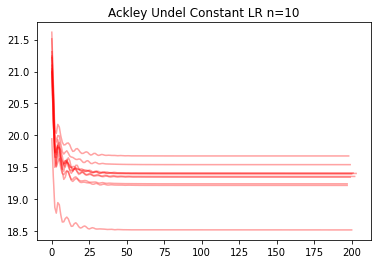

0.07888415987796998


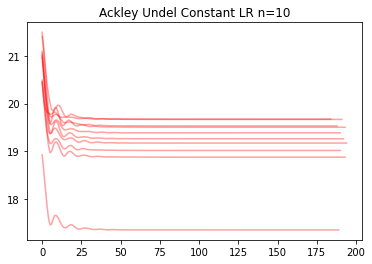

1.0718378451729293


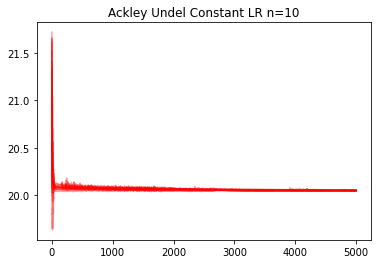

1.0936639463613766


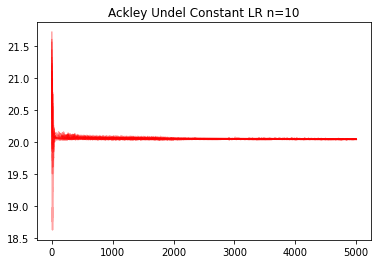

1.2752070393118395


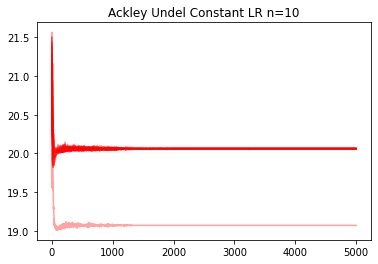

1.1629631830890976


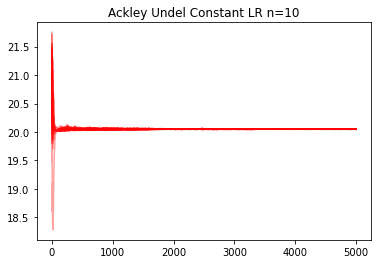

1.2802895605292102


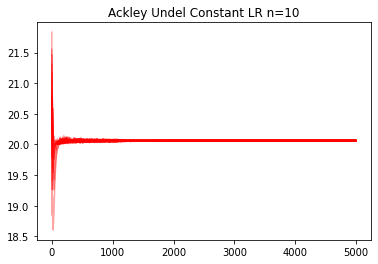

{'max_learning_rate': 2.162397829480813, 'min_learning_rate': 0.2233362511931281, 'step_size': 270}


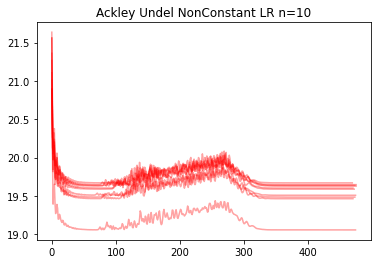

{'max_learning_rate': 3.485094602156221, 'min_learning_rate': 0.7199175745228622, 'step_size': 950}


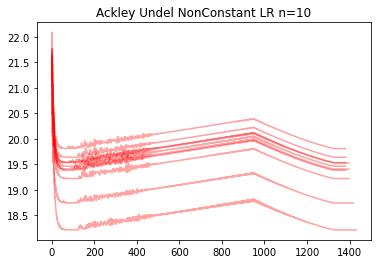

{'max_learning_rate': 2.4792016987682377, 'min_learning_rate': 0.9270563389907918, 'step_size': 450}


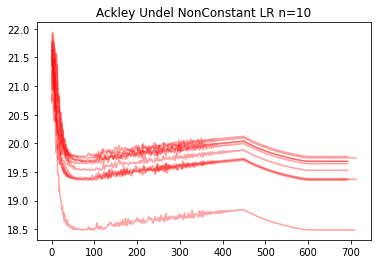

{'max_learning_rate': 3.948459584556327, 'min_learning_rate': 0.4901573731811285, 'step_size': 210}


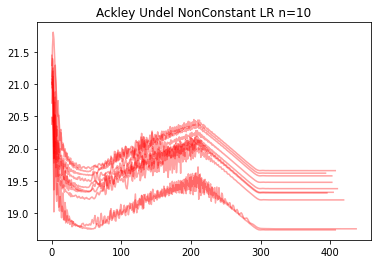

{'max_learning_rate': 4.627580260252022, 'min_learning_rate': 0.6895611632934199, 'step_size': 1330}


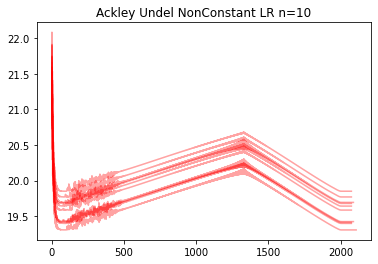

{'max_learning_rate': 4.62556350438777, 'min_learning_rate': 0.4896980043380412, 'step_size': 2010}


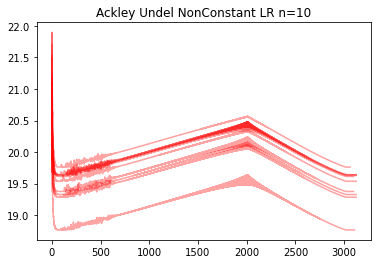

{'max_learning_rate': 1.036592270209848, 'min_learning_rate': 0.10060352070612863, 'step_size': 2100}


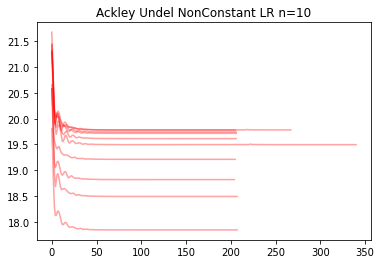

{'max_learning_rate': 3.99559596738038, 'min_learning_rate': 0.35401449721601086, 'step_size': 360}


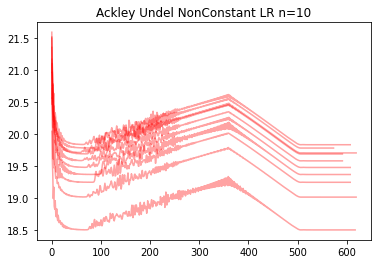

{'max_learning_rate': 2.7657415685194238, 'min_learning_rate': 0.3603844429458287, 'step_size': 2490}


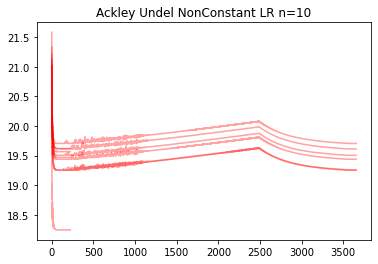

{'max_learning_rate': 2.0426794017826926, 'min_learning_rate': 0.21643630433449534, 'step_size': 570}


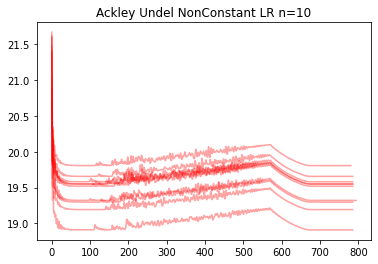

{'max_learning_rate': 3.9686206072908865, 'min_learning_rate': 0.6042034863171941, 'step_size': 900}


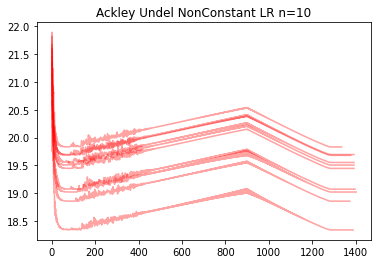

{'max_learning_rate': 1.5683490885405862, 'min_learning_rate': 0.8030886629220343, 'step_size': 1570}


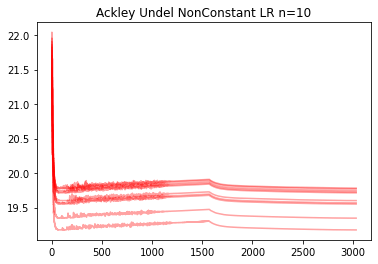

{'max_learning_rate': 2.3483052731466874, 'min_learning_rate': 0.13184462512850964, 'step_size': 630}


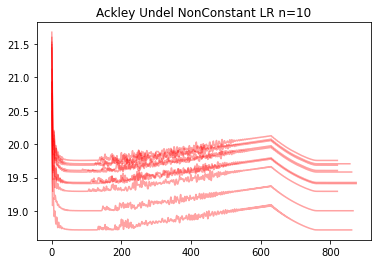

{'max_learning_rate': 2.9575618782193946, 'min_learning_rate': 0.9305409955511015, 'step_size': 1000}


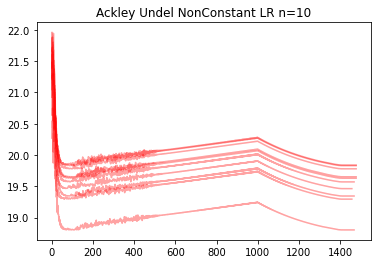

{'max_learning_rate': 4.993005713178601, 'min_learning_rate': 0.9144015658637569, 'step_size': 870}


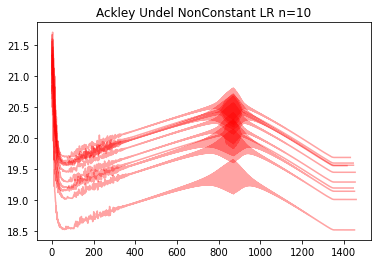

{'max_learning_rate': 2.3707444749578155, 'min_learning_rate': 0.33790809237080216, 'step_size': 450}


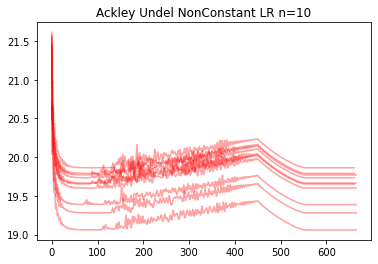

{'max_learning_rate': 3.654805362481217, 'min_learning_rate': 0.2541312040842377, 'step_size': 1040}


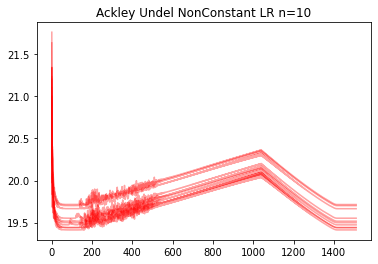

{'max_learning_rate': 3.485094602156221, 'min_learning_rate': 0.7199175745228622, 'step_size': 950}


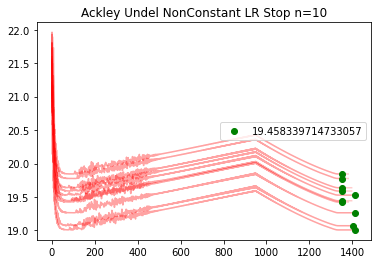

{'max_learning_rate': 2.4792016987682377, 'min_learning_rate': 0.9270563389907918, 'step_size': 450}


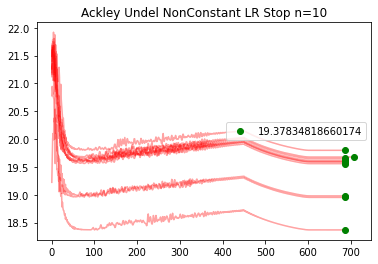

{'max_learning_rate': 2.7657415685194238, 'min_learning_rate': 0.3603844429458287, 'step_size': 2490}


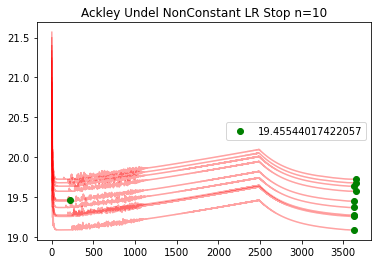

{'max_learning_rate': 2.0426794017826926, 'min_learning_rate': 0.21643630433449534, 'step_size': 570}


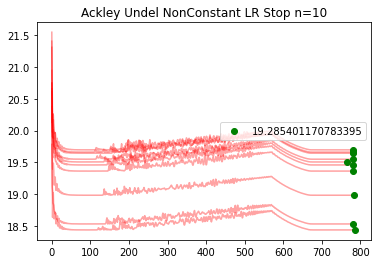

{'max_learning_rate': 2.3483052731466874, 'min_learning_rate': 0.13184462512850964, 'step_size': 630}


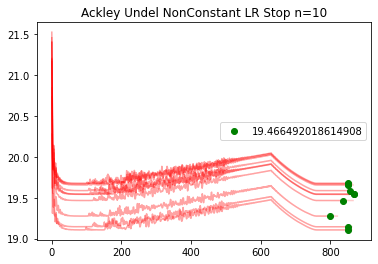

{'max_learning_rate': 4.993005713178601, 'min_learning_rate': 0.9144015658637569, 'step_size': 870}


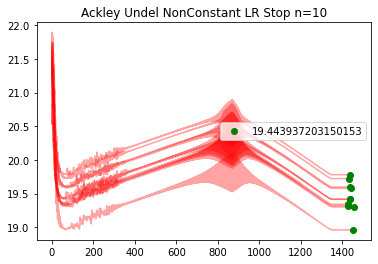

{'max_learning_rate': 3.654805362481217, 'min_learning_rate': 0.2541312040842377, 'step_size': 1040}


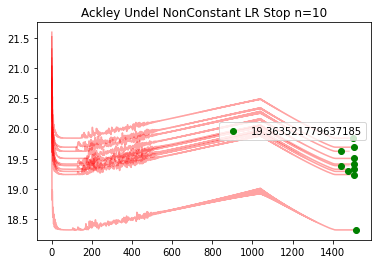

In [9]:
#symmetric with constant learning rate
analyzer(ack_undel, dom_range=[-32., 32.], Title="Ackley Undel Constant LR", symmetric_delays=False, use_delays=False, constant_learning_rate=True, dim=10)
#symmetric nonconstant learning rate
analyzer(ack_undel_lr, dom_range=[-32., 32.], Title="Ackley Undel NonConstant LR", symmetric_delays=False, use_delays=False, constant_learning_rate=False, num_tests=10, dim=10)
#symmertic non constant learning rate with early stopping 
analyzer(ack_undel_lr_stop, dom_range=[-32.,32.], Title="Ackley Undel NonConstant LR Stop", symmetric_delays=False, use_delays=False, constant_learning_rate=False, num_tests=10, dim=10, early_stopping=True)

### 100 Dimensional Ackley Tests

##### Symmetric Results

0.2367446816236879


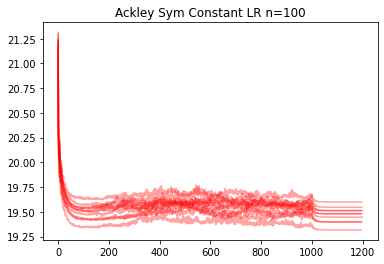

0.6875561376312982


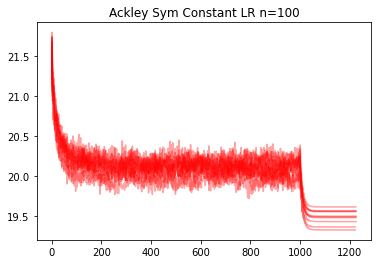

1.3390967551601636


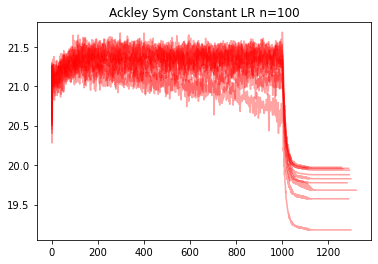

0.23882107608149789


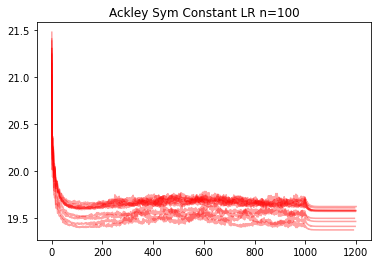

0.11027060775892661


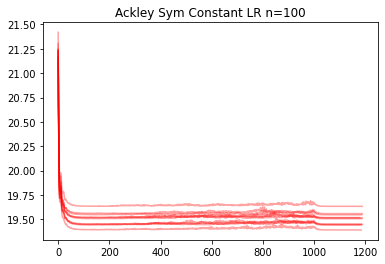

0.5894861512993124


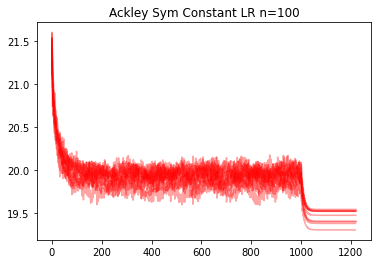

1.4423391069799791


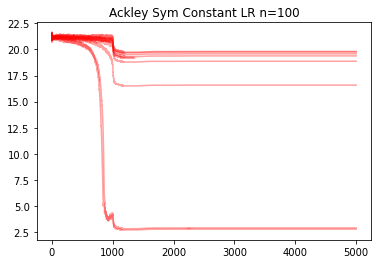

1.2627219899908013


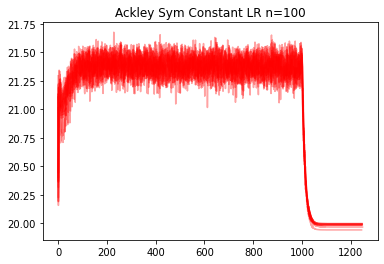

1.2305434442196774


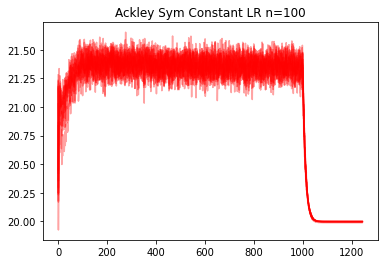

0.12568706696556362


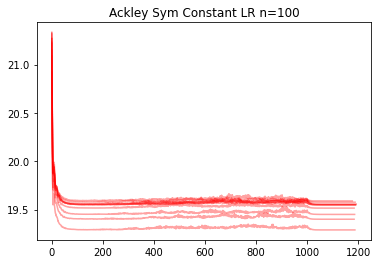

{'max_learning_rate': 2.3406146448066574, 'min_learning_rate': 0.20435586412746767, 'step_size': 1010}


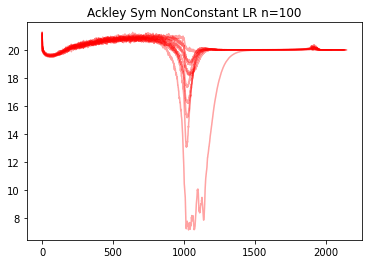

{'max_learning_rate': 1.5246926383175914, 'min_learning_rate': 0.7064529091186603, 'step_size': 2220}


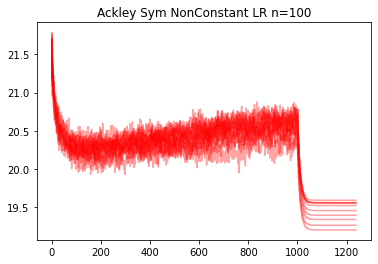

{'max_learning_rate': 3.7283707966383832, 'min_learning_rate': 0.10472419338063169, 'step_size': 1100}


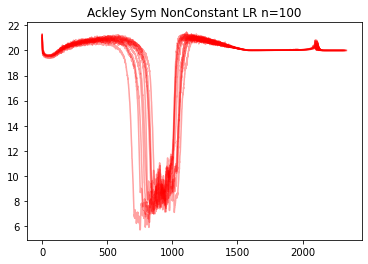

{'max_learning_rate': 2.8482223871086356, 'min_learning_rate': 0.9280142723188163, 'step_size': 1500}


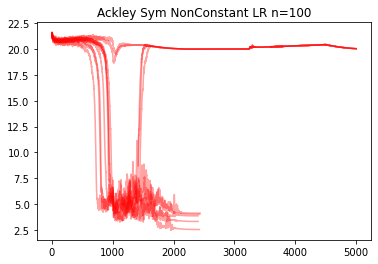

{'max_learning_rate': 1.8311902465945662, 'min_learning_rate': 0.25947495469972937, 'step_size': 810}


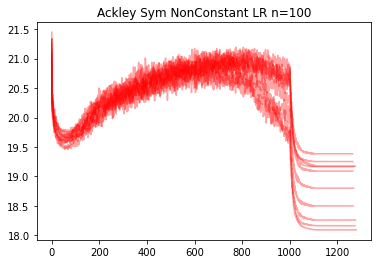

{'max_learning_rate': 1.9324509426905474, 'min_learning_rate': 0.358249663266194, 'step_size': 2300}


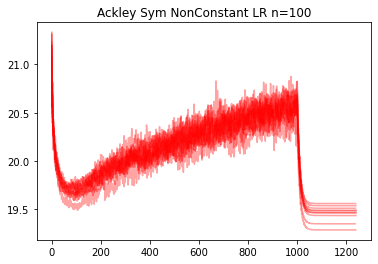

{'max_learning_rate': 2.2202182935831605, 'min_learning_rate': 0.9095628920469846, 'step_size': 600}


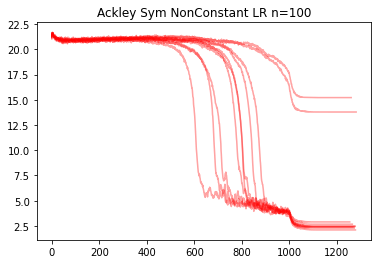

{'max_learning_rate': 2.550293436438124, 'min_learning_rate': 0.2952840039534936, 'step_size': 1140}


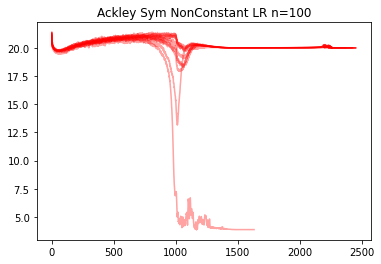

{'max_learning_rate': 3.3799780324494684, 'min_learning_rate': 0.45756377175478935, 'step_size': 720}


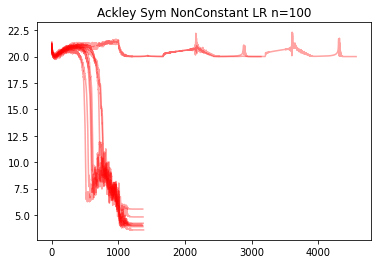

{'max_learning_rate': 2.43673209776345, 'min_learning_rate': 0.39419092488443797, 'step_size': 1690}


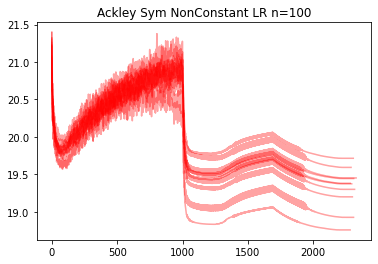

{'max_learning_rate': 3.0978249188505136, 'min_learning_rate': 0.5569083789040644, 'step_size': 170}


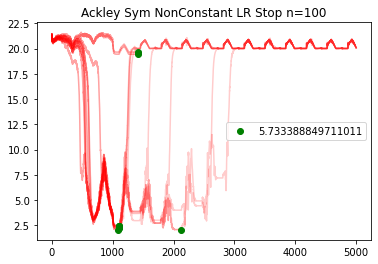

{'max_learning_rate': 2.5573425010391793, 'min_learning_rate': 0.25564018292494967, 'step_size': 340}


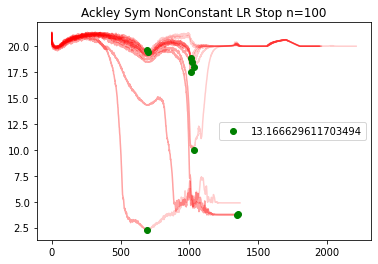

{'max_learning_rate': 3.716492434887711, 'min_learning_rate': 0.3861062499975233, 'step_size': 1340}


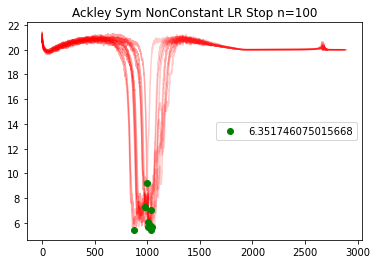

{'max_learning_rate': 4.722737529188188, 'min_learning_rate': 0.6844670804605413, 'step_size': 570}


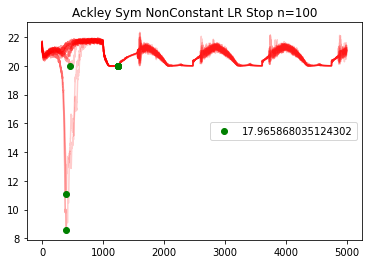

{'max_learning_rate': 4.064566338014468, 'min_learning_rate': 0.15394404467926412, 'step_size': 1350}


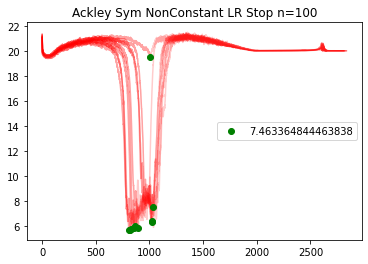

{'max_learning_rate': 3.9700547662287695, 'min_learning_rate': 0.4103049524964203, 'step_size': 980}


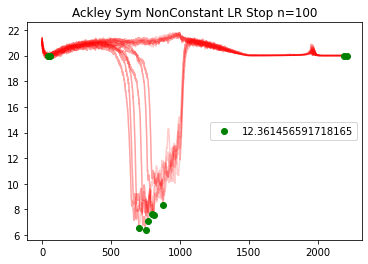

{'max_learning_rate': 4.556173588180253, 'min_learning_rate': 0.24501973729686183, 'step_size': 520}


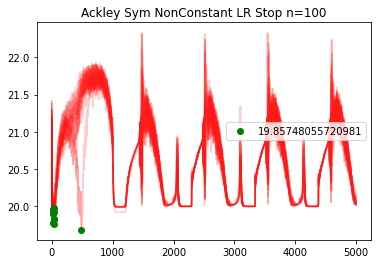

{'max_learning_rate': 1.4994823988399895, 'min_learning_rate': 0.5839179326017547, 'step_size': 1230}


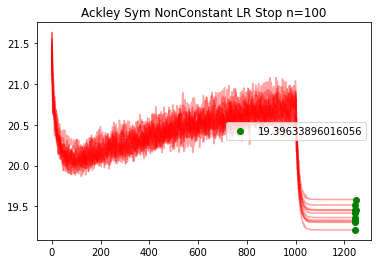

{'max_learning_rate': 4.082747653833175, 'min_learning_rate': 0.6029310464822911, 'step_size': 1770}


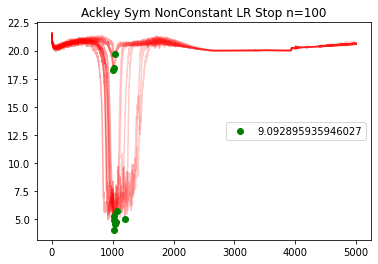

{'max_learning_rate': 2.5991657483884576, 'min_learning_rate': 0.2981984741646861, 'step_size': 860}


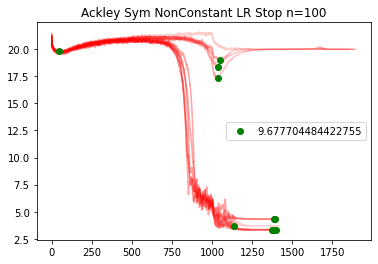

In [10]:
#symmetric with constant learning rate
analyzer(ack_del_sym, dom_range=[-32., 32.], Title="Ackley Sym Constant LR", constant_learning_rate=True, symmetric_delays=True, dim=100)
#symmetric nonconstant learning rate
analyzer(ack_del_lr_sym, dom_range=[-32., 32.], Title="Ackley Sym NonConstant LR", constant_learning_rate=False, symmetric_delays=True, num_tests=10, dim=100)
#symmertic non constant learning rate with early stopping 
analyzer(ack_del_lr_sym_stop, dom_range=[-32.,32.], Title="Ackley Sym NonConstant LR Stop", constant_learning_rate=False, symmetric_delays=True, num_tests=10, dim=100, early_stopping=True)

#### Nonsymmetric Results

0.0850792398813977


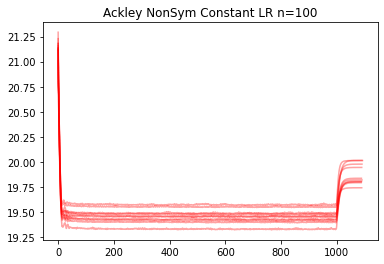

0.028188983093924258


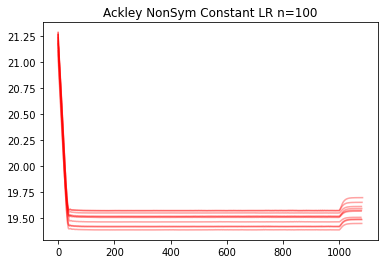

0.026672529594611725


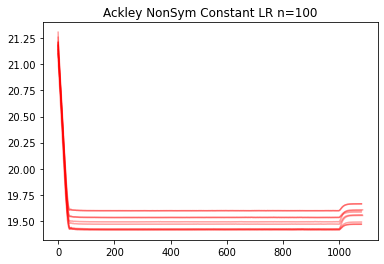

0.11400672295239292


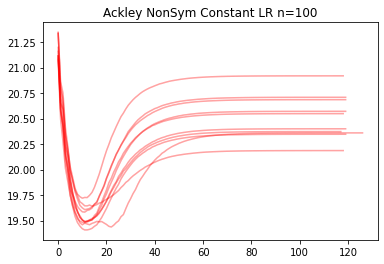

0.6093178028428891


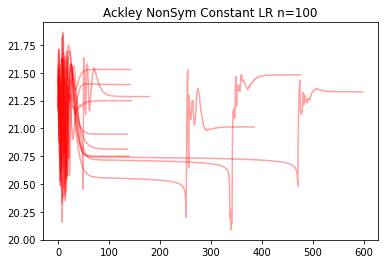

1.3718418981795004


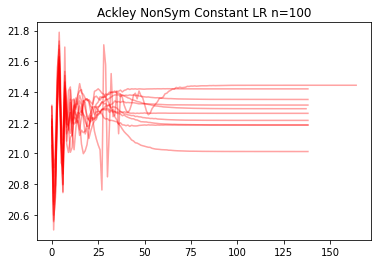

0.5971495116176732


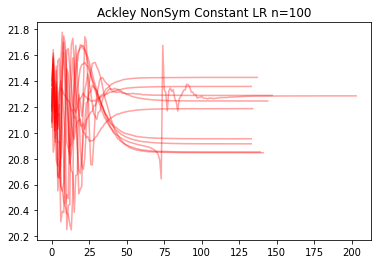

0.08744118547339995


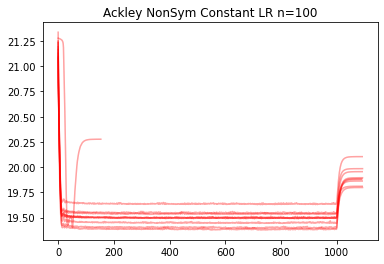

1.1145957729238334


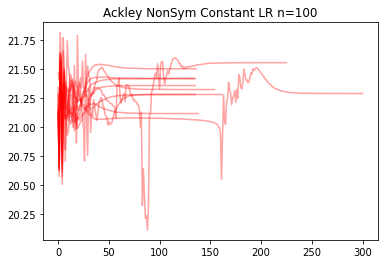

1.4977280645733801


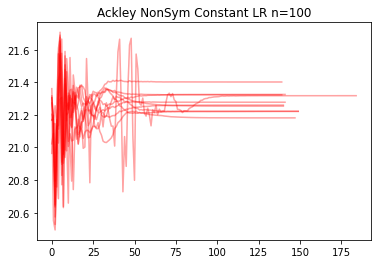

{'max_learning_rate': 1.6638360033233228, 'min_learning_rate': 0.3934261633628238, 'step_size': 1760}


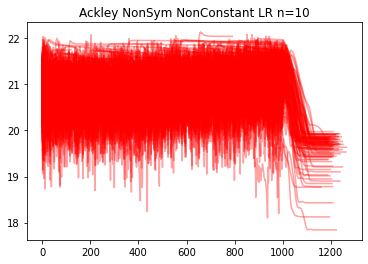

{'max_learning_rate': 3.8629958737667724, 'min_learning_rate': 0.5092313644807007, 'step_size': 550}


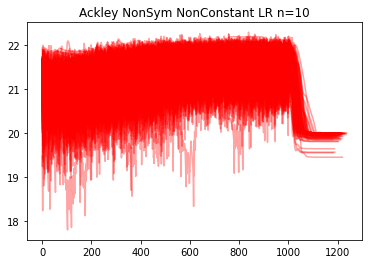

{'max_learning_rate': 2.769722511722531, 'min_learning_rate': 0.42252265237861364, 'step_size': 2160}


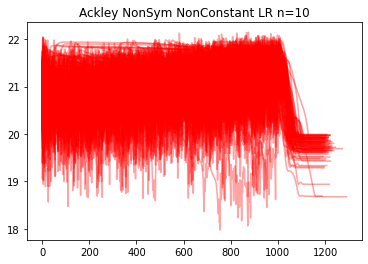

{'max_learning_rate': 3.223815000050883, 'min_learning_rate': 0.17379226466539116, 'step_size': 300}


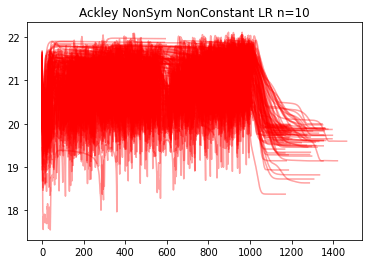

{'max_learning_rate': 1.847130716520324, 'min_learning_rate': 0.9822762839847528, 'step_size': 2130}


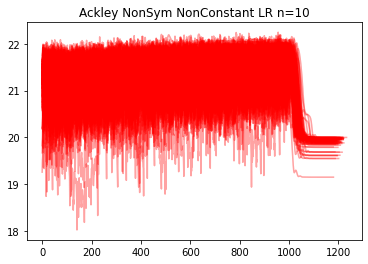

{'max_learning_rate': 1.7009739050508061, 'min_learning_rate': 0.821543889353341, 'step_size': 130}


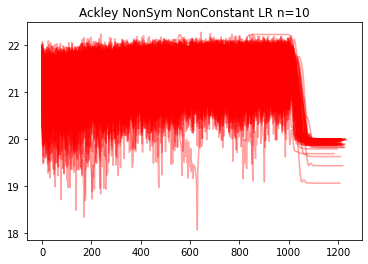

{'max_learning_rate': 1.437168918046567, 'min_learning_rate': 0.290442991692353, 'step_size': 2200}


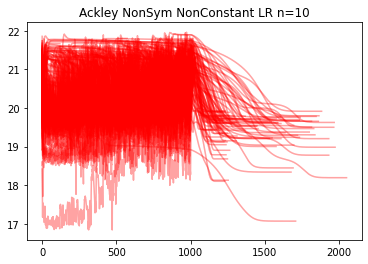

{'max_learning_rate': 1.7091928800020273, 'min_learning_rate': 0.3137430545658315, 'step_size': 1380}


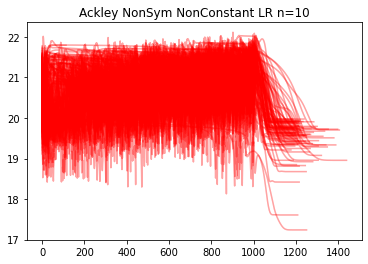

{'max_learning_rate': 2.2728718792425546, 'min_learning_rate': 0.9624653296857517, 'step_size': 1300}


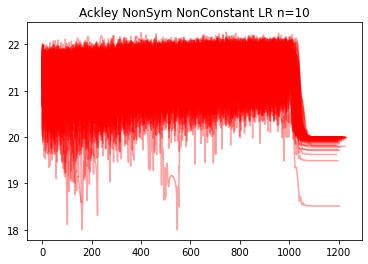

{'max_learning_rate': 2.0513410763546087, 'min_learning_rate': 0.5180623763768937, 'step_size': 700}


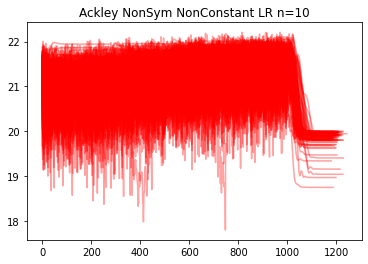

{'max_learning_rate': 1.4229203743264347, 'min_learning_rate': 0.16753070023245276, 'step_size': 260}


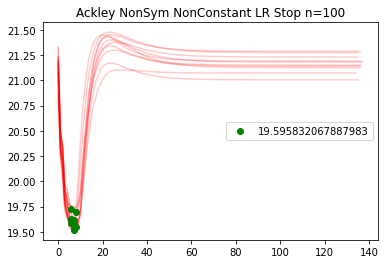

{'max_learning_rate': 3.870415669108335, 'min_learning_rate': 0.41846860866543323, 'step_size': 1000}


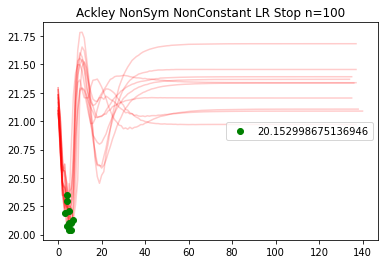

{'max_learning_rate': 1.564903270384412, 'min_learning_rate': 0.557399742911521, 'step_size': 470}


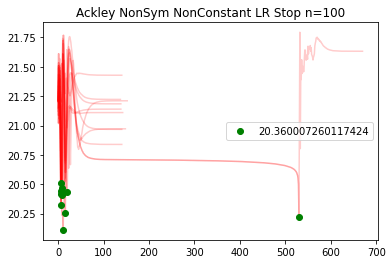

{'max_learning_rate': 1.323734239574908, 'min_learning_rate': 0.31090070675205883, 'step_size': 2450}


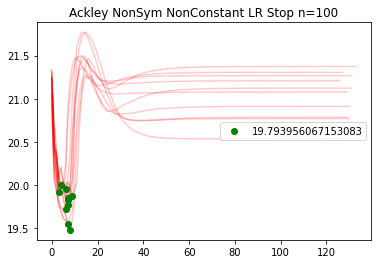

{'max_learning_rate': 2.4641598648399263, 'min_learning_rate': 0.10871693456337687, 'step_size': 200}


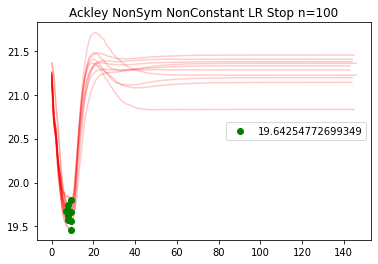

{'max_learning_rate': 2.2932706550608457, 'min_learning_rate': 0.4982134442163112, 'step_size': 1990}


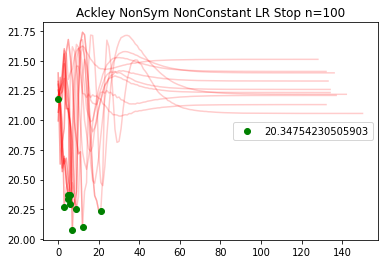

{'max_learning_rate': 1.6238884901677229, 'min_learning_rate': 0.3350375778978507, 'step_size': 1140}


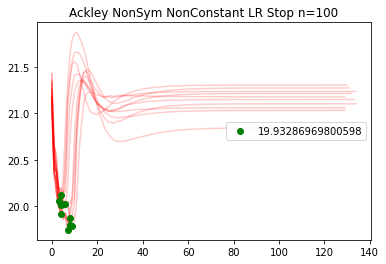

{'max_learning_rate': 4.293181335567169, 'min_learning_rate': 0.43987800067071503, 'step_size': 120}


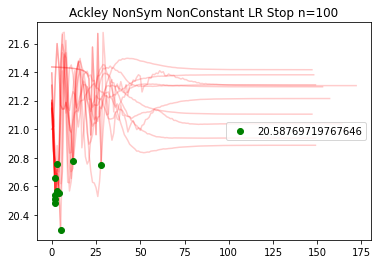

{'max_learning_rate': 1.3090389728411558, 'min_learning_rate': 0.1414431058221307, 'step_size': 220}


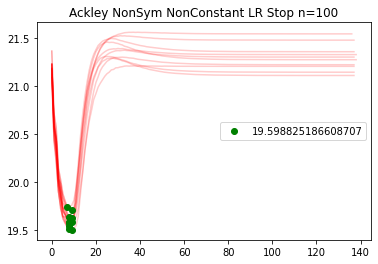

{'max_learning_rate': 1.4673801666882937, 'min_learning_rate': 0.6577905305433761, 'step_size': 1530}


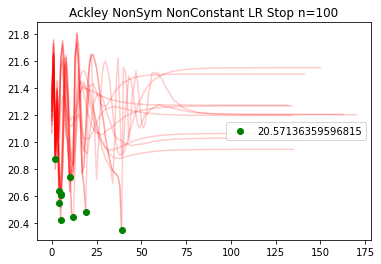

In [11]:
#symmetric with constant learning rate
analyzer(ack_del_unsym, dom_range=[-32., 32.], Title="Ackley NonSym Constant LR", symmetric_delays=False, constant_learning_rate=True, dim=100)
#symmetric nonconstant learning rate
analyzer(ack_del_lr_nonsym, dom_range=[-32., 32.], Title="Ackley NonSym NonConstant LR", symmetric_delays=False, constant_learning_rate=False, num_tests=100, dim=10)
#symmertic non constant learning rate with early stopping 
analyzer(ack_del_lr_nonsym_stop, dom_range=[-32.,32.], Title="Ackley NonSym NonConstant LR Stop", symmetric_delays=False, constant_learning_rate=False, num_tests=10, dim=100, early_stopping=True)

#### Undelayed Results

0.09327249304805008


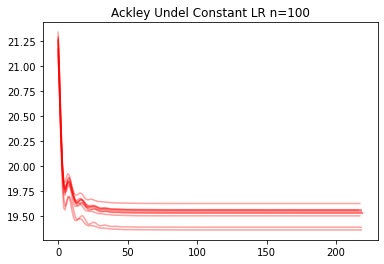

0.09874118308995838


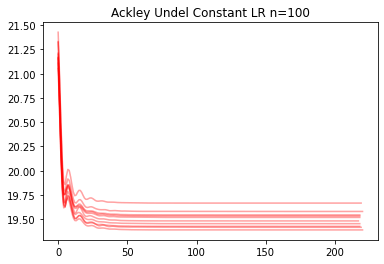

0.05140319486185507


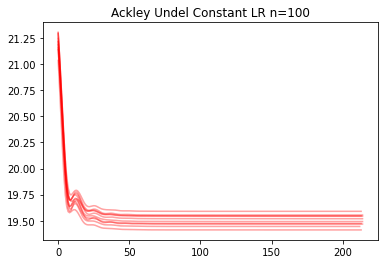

0.3521727199917074


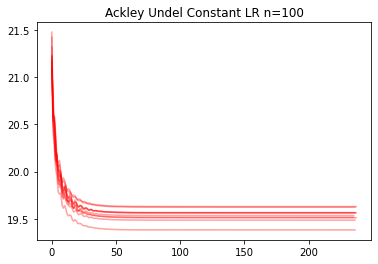

0.28318446681197346


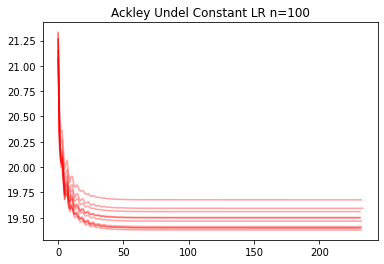

1.137438840195812


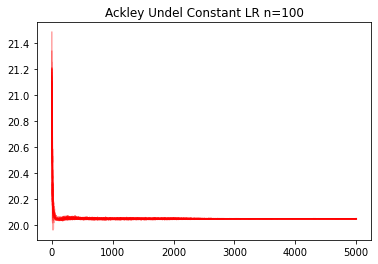

0.804658120476589


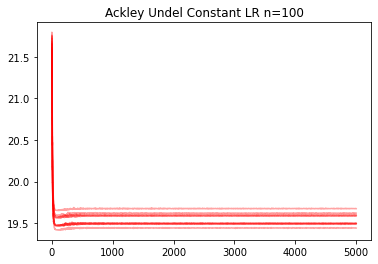

0.3670866985222844


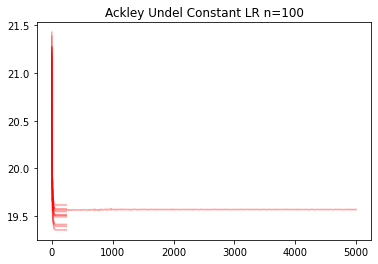

1.3818115630491503


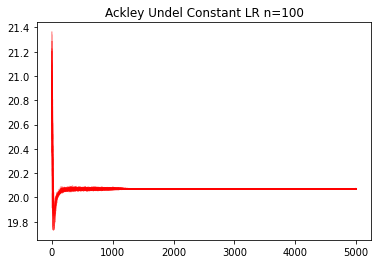

0.7016697064535496


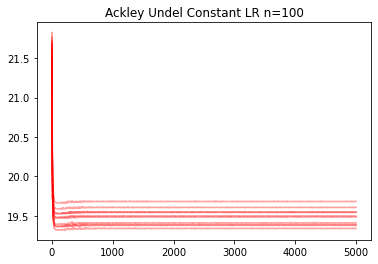

{'max_learning_rate': 2.594269858807263, 'min_learning_rate': 0.8071604635624982, 'step_size': 830}


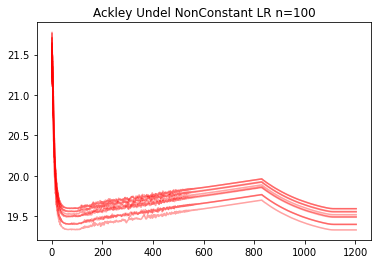

{'max_learning_rate': 2.6157715074366603, 'min_learning_rate': 0.20238671956681564, 'step_size': 250}


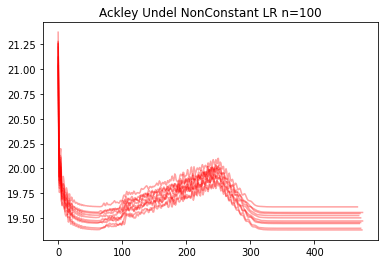

{'max_learning_rate': 4.483661312471584, 'min_learning_rate': 0.531471108287326, 'step_size': 1500}


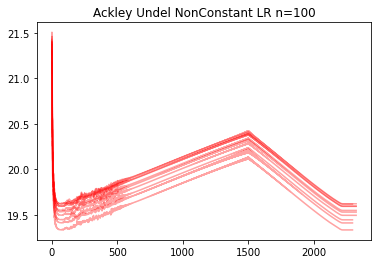

{'max_learning_rate': 1.6747270076938312, 'min_learning_rate': 0.6249791950444612, 'step_size': 310}


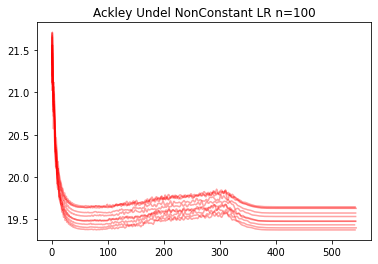

{'max_learning_rate': 3.781080025273468, 'min_learning_rate': 0.5032071021804279, 'step_size': 1060}


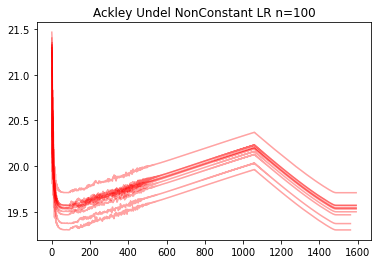

{'max_learning_rate': 3.574652572644485, 'min_learning_rate': 0.7536922439723885, 'step_size': 1220}


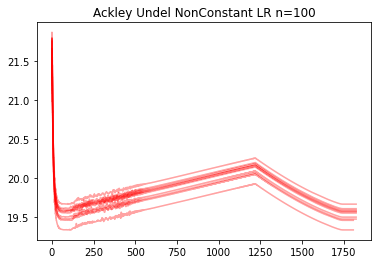

{'max_learning_rate': 3.9623957423731055, 'min_learning_rate': 0.6376300344613288, 'step_size': 2060}


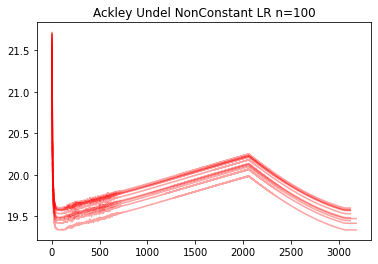

{'max_learning_rate': 2.7032020346657286, 'min_learning_rate': 0.4838264551112632, 'step_size': 660}


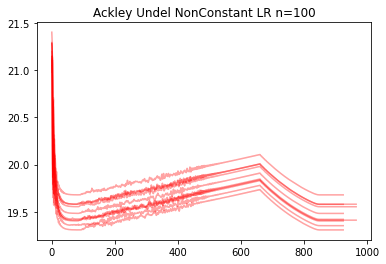

{'max_learning_rate': 2.6778804144630044, 'min_learning_rate': 0.2546333446881509, 'step_size': 1690}


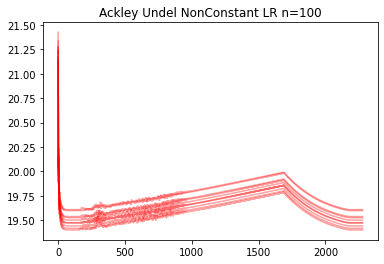

{'max_learning_rate': 1.6426629814461513, 'min_learning_rate': 0.3113149782450255, 'step_size': 170}


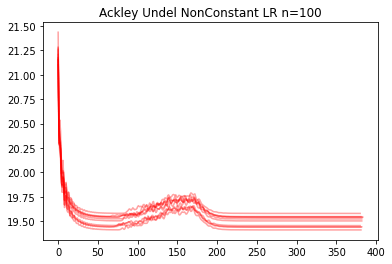

{'max_learning_rate': 2.3315785230132757, 'min_learning_rate': 0.5536797866288716, 'step_size': 680}


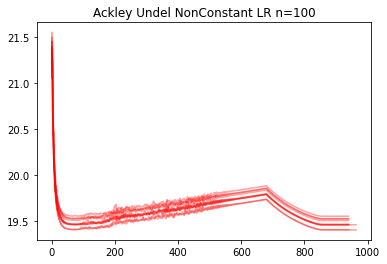

{'max_learning_rate': 1.8503711236359819, 'min_learning_rate': 0.5760483838988582, 'step_size': 900}


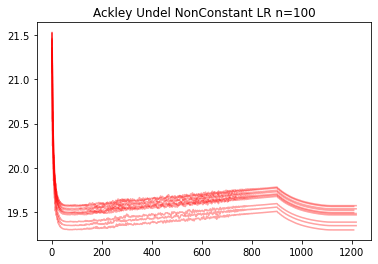

{'max_learning_rate': 1.9975409865456344, 'min_learning_rate': 0.5985846385870722, 'step_size': 1560}


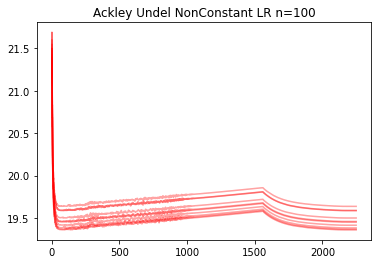

{'max_learning_rate': 1.9346551937405907, 'min_learning_rate': 0.6913066194666921, 'step_size': 990}


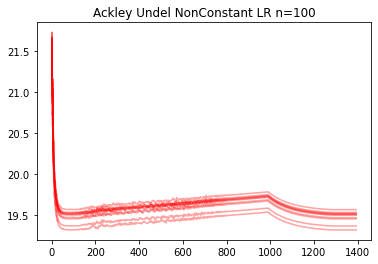

{'max_learning_rate': 4.630060571484982, 'min_learning_rate': 0.3272501911451763, 'step_size': 2200}


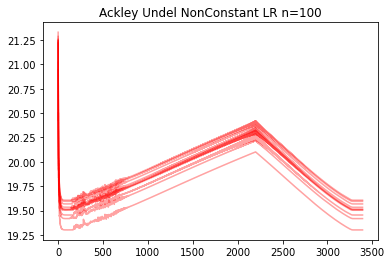

{'max_learning_rate': 3.940606474086075, 'min_learning_rate': 0.26791237762731046, 'step_size': 1760}


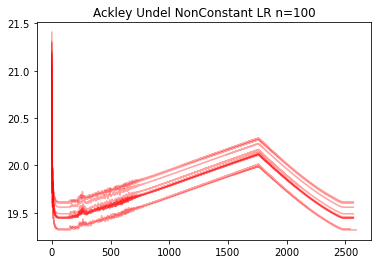

{'max_learning_rate': 1.565312307623479, 'min_learning_rate': 0.47448722124390513, 'step_size': 1750}


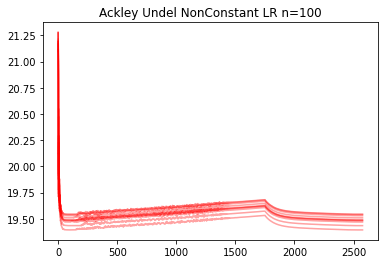

{'max_learning_rate': 2.9938985361306303, 'min_learning_rate': 0.2022298589892001, 'step_size': 2300}


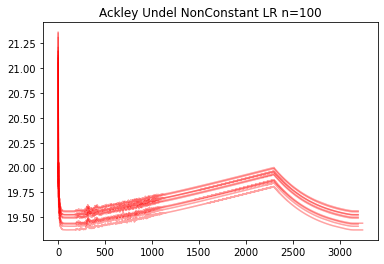

{'max_learning_rate': 3.5017297504930696, 'min_learning_rate': 0.28847232711058557, 'step_size': 680}


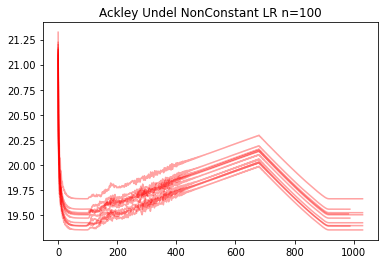

{'max_learning_rate': 3.058889763399436, 'min_learning_rate': 0.1710991972250242, 'step_size': 1140}


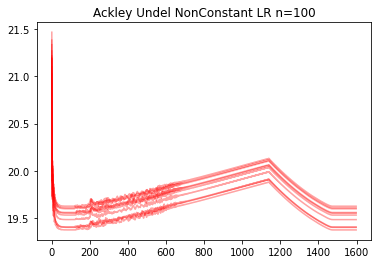

{'max_learning_rate': 2.6157715074366603, 'min_learning_rate': 0.20238671956681564, 'step_size': 250}


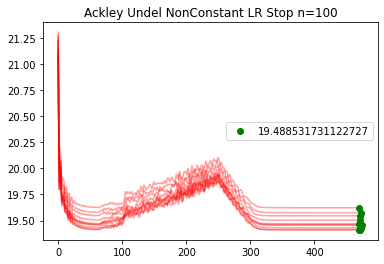

{'max_learning_rate': 3.574652572644485, 'min_learning_rate': 0.7536922439723885, 'step_size': 1220}


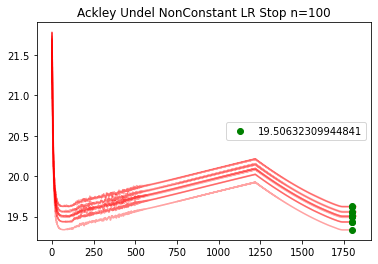

{'max_learning_rate': 3.9623957423731055, 'min_learning_rate': 0.6376300344613288, 'step_size': 2060}


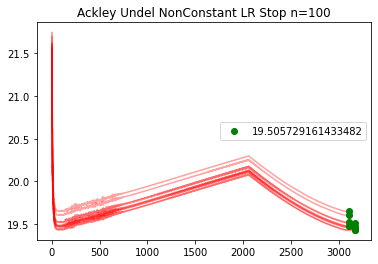

{'max_learning_rate': 2.6778804144630044, 'min_learning_rate': 0.2546333446881509, 'step_size': 1690}


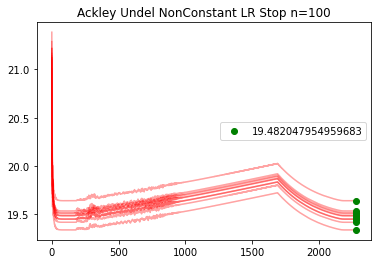

{'max_learning_rate': 2.3315785230132757, 'min_learning_rate': 0.5536797866288716, 'step_size': 680}


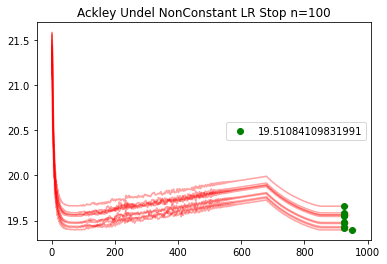

{'max_learning_rate': 1.9975409865456344, 'min_learning_rate': 0.5985846385870722, 'step_size': 1560}


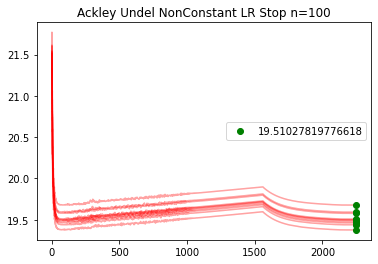

{'max_learning_rate': 1.9346551937405907, 'min_learning_rate': 0.6913066194666921, 'step_size': 990}


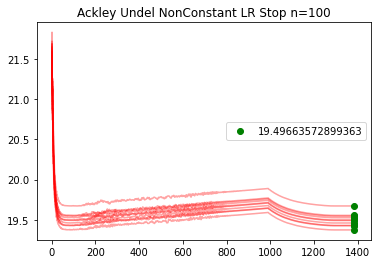

{'max_learning_rate': 3.940606474086075, 'min_learning_rate': 0.26791237762731046, 'step_size': 1760}


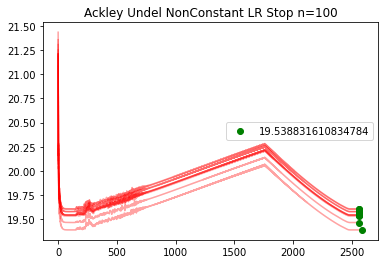

{'max_learning_rate': 2.9938985361306303, 'min_learning_rate': 0.2022298589892001, 'step_size': 2300}


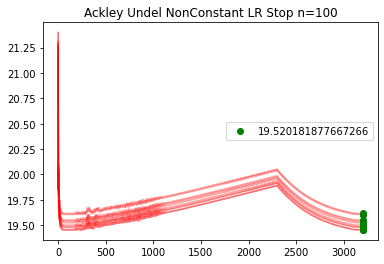

{'max_learning_rate': 3.5017297504930696, 'min_learning_rate': 0.28847232711058557, 'step_size': 680}


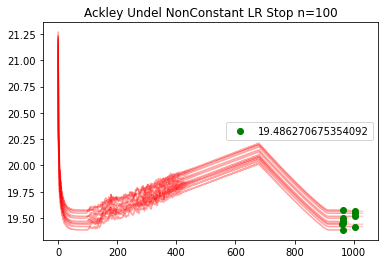

In [12]:
#symmetric with constant learning rate
analyzer(ack_undel, dom_range=[-32., 32.], Title="Ackley Undel Constant LR", symmetric_delays=False, use_delays=False, constant_learning_rate=True, dim=100)
#symmetric nonconstant learning rate
analyzer(ack_undel_lr, dom_range=[-32., 32.], Title="Ackley Undel NonConstant LR", symmetric_delays=False, use_delays=False, constant_learning_rate=False, num_tests=10, dim=100)
#symmertic non constant learning rate with early stopping 
analyzer(ack_undel_lr_stop, dom_range=[-32.,32.], Title="Ackley Undel NonConstant LR Stop", symmetric_delays=False, use_delays=False, constant_learning_rate=False, num_tests=10, dim=100, early_stopping=True)

### 1000 Dimensional Results

##### Symmetric Results

0.7636829711056174


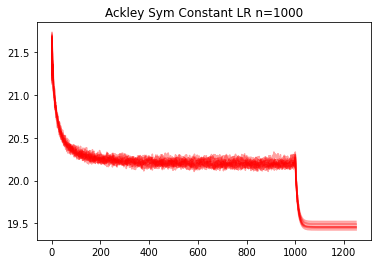

0.7799405609742002


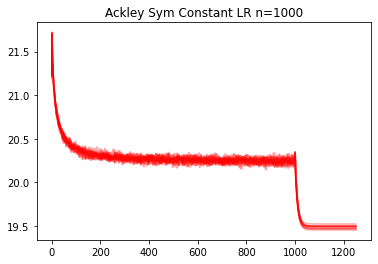

0.7335232234752684


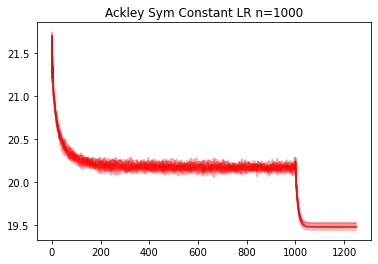

1.3081105224648246


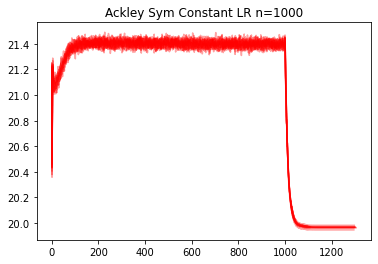

0.8849452019700107


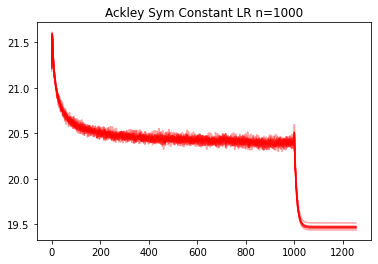

0.3060406148238136


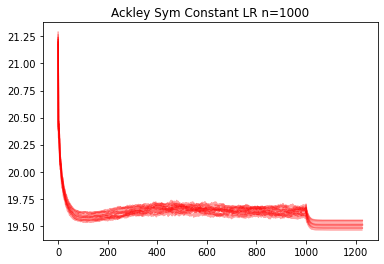

0.04426193124322825


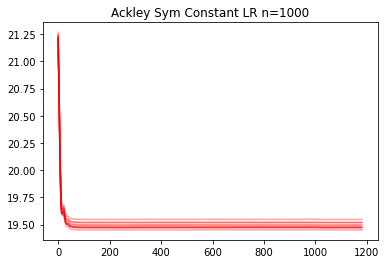

0.651145735365478


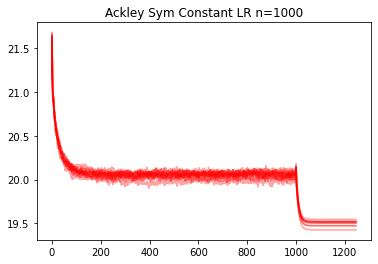

1.393677219245844


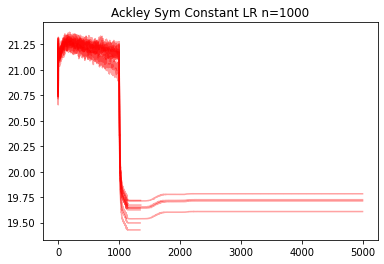

0.8595340584667027


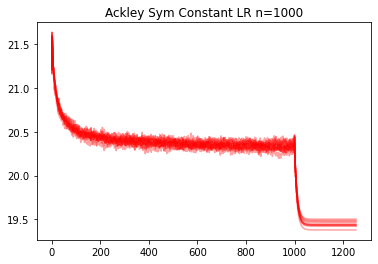

{'max_learning_rate': 3.5064873512355987, 'min_learning_rate': 0.3896335864655782, 'step_size': 530}


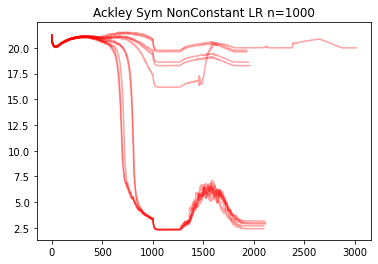

{'max_learning_rate': 2.102161251175967, 'min_learning_rate': 0.7567330639801254, 'step_size': 320}


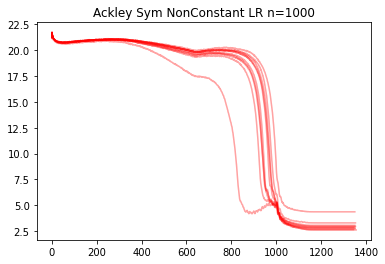

{'max_learning_rate': 1.289539568599754, 'min_learning_rate': 0.6697471439443531, 'step_size': 420}


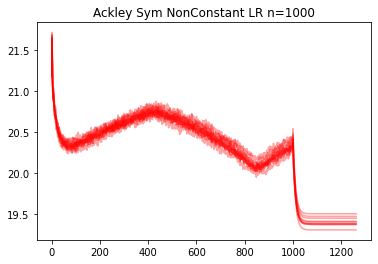

{'max_learning_rate': 4.188816978448172, 'min_learning_rate': 0.24434416784214952, 'step_size': 680}


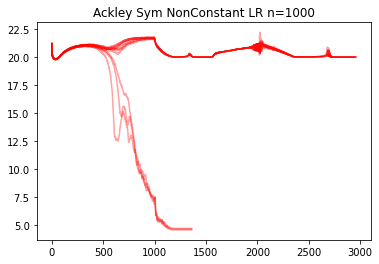

{'max_learning_rate': 3.038081888732832, 'min_learning_rate': 0.3476467939418293, 'step_size': 1030}


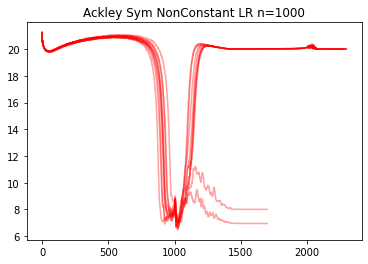

{'max_learning_rate': 3.243827279996392, 'min_learning_rate': 0.5918615734916783, 'step_size': 1350}


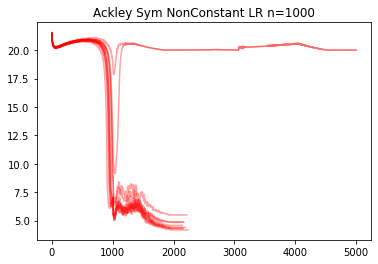

{'max_learning_rate': 2.4233561882082544, 'min_learning_rate': 0.3865099451586446, 'step_size': 1750}


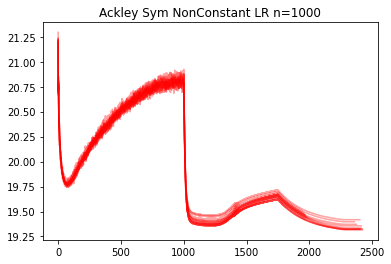

{'max_learning_rate': 3.6140489295622604, 'min_learning_rate': 0.3911522423559166, 'step_size': 1950}


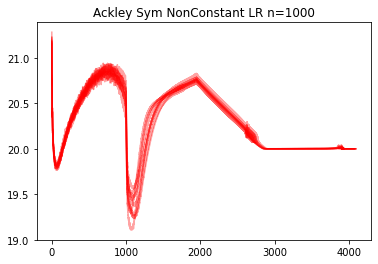

{'max_learning_rate': 2.135015496604078, 'min_learning_rate': 0.4669762415527333, 'step_size': 170}


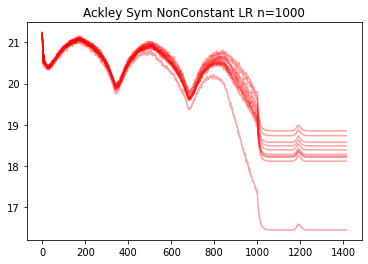

{'max_learning_rate': 3.8602867403255043, 'min_learning_rate': 0.17193576336255018, 'step_size': 1900}


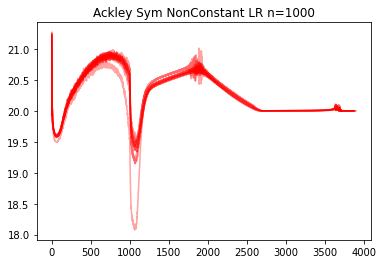

{'max_learning_rate': 3.3031800070175152, 'min_learning_rate': 0.8349895077560979, 'step_size': 2380}


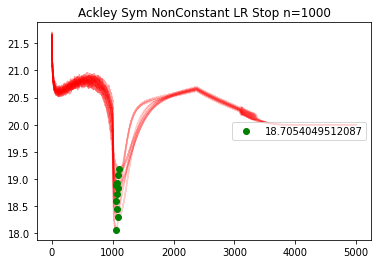

{'max_learning_rate': 2.8687478384155707, 'min_learning_rate': 0.3800881136545512, 'step_size': 960}


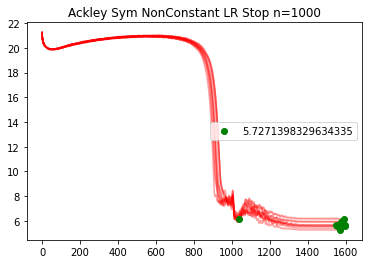

{'max_learning_rate': 4.986110693777745, 'min_learning_rate': 0.7053076921665906, 'step_size': 1760}


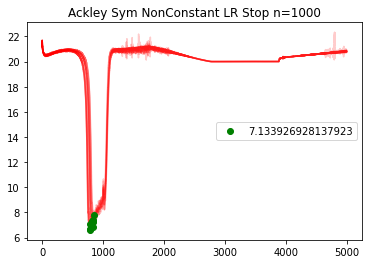

{'max_learning_rate': 2.3866745722541793, 'min_learning_rate': 0.502455583876072, 'step_size': 520}


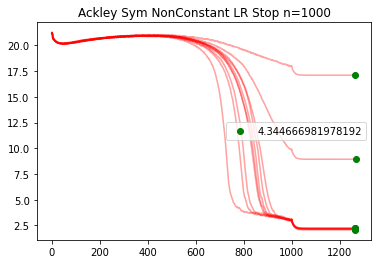

{'max_learning_rate': 1.061025932916898, 'min_learning_rate': 0.6899285378097366, 'step_size': 1330}


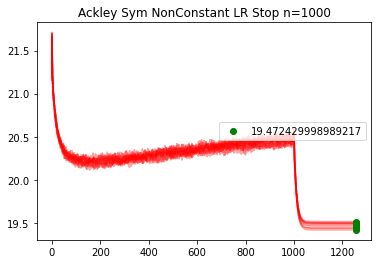

{'max_learning_rate': 2.905647202962281, 'min_learning_rate': 0.6510502282325783, 'step_size': 1470}


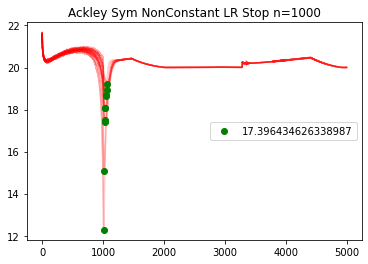

{'max_learning_rate': 3.480650333837514, 'min_learning_rate': 0.24600303877257115, 'step_size': 1430}


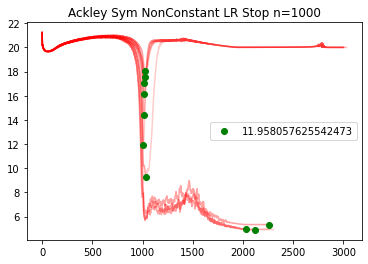

{'max_learning_rate': 4.427037758277974, 'min_learning_rate': 0.17898604005272636, 'step_size': 260}


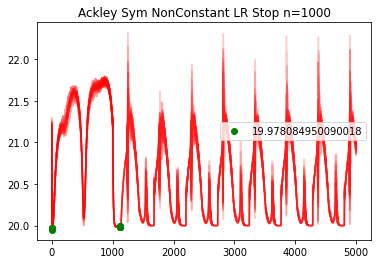

{'max_learning_rate': 1.4542516299957797, 'min_learning_rate': 0.3944060357384157, 'step_size': 1410}


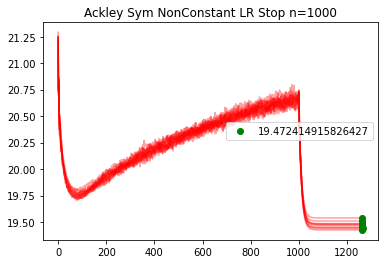

{'max_learning_rate': 3.109638955943782, 'min_learning_rate': 0.1451291495418593, 'step_size': 1000}


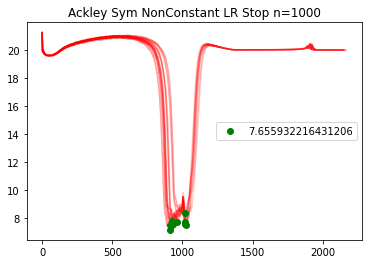

In [13]:
#symmetric with constant learning rate
analyzer(ack_del_sym, dom_range=[-32., 32.], Title="Ackley Sym Constant LR", constant_learning_rate=True, symmetric_delays=True, dim=1000)
#symmetric nonconstant learning rate
analyzer(ack_del_lr_sym, dom_range=[-32., 32.], Title="Ackley Sym NonConstant LR", constant_learning_rate=False, symmetric_delays=True, num_tests=10, dim=1000)
#symmertic non constant learning rate with early stopping 
analyzer(ack_del_lr_sym_stop, dom_range=[-32.,32.], Title="Ackley Sym NonConstant LR Stop", constant_learning_rate=False, symmetric_delays=True, num_tests=10, dim=1000, early_stopping=True)

#### Undelayed Results

1.0066023557560235


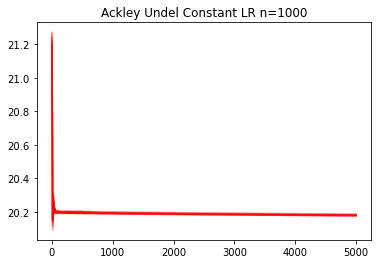

0.7512097210516451


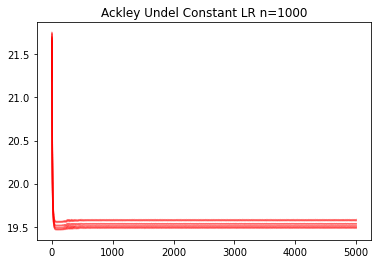

0.05931574004073687


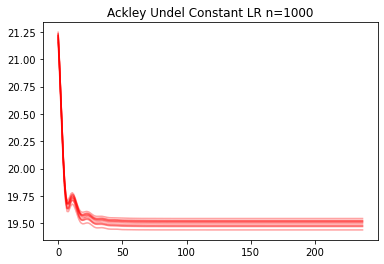

0.2843553958587831


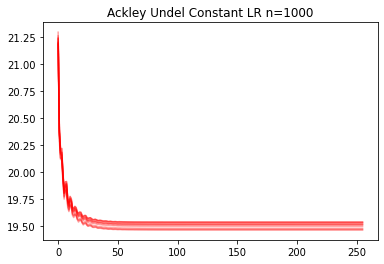

0.009002931383098989


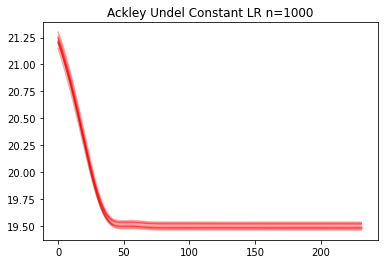

0.21046439426814134


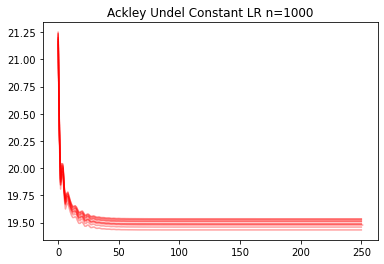

0.3457215532163573


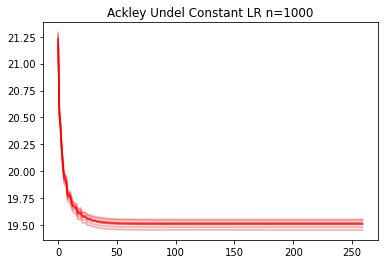

0.22073856292508418


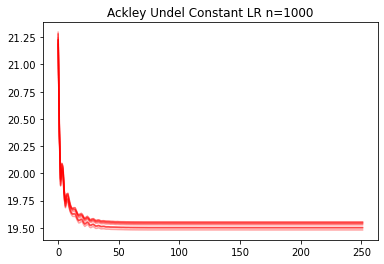

0.22064951389860865


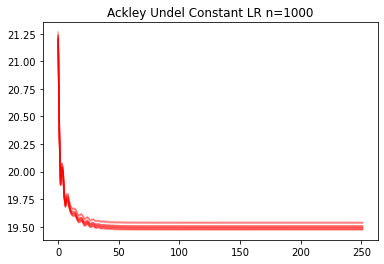

0.09609674759893438


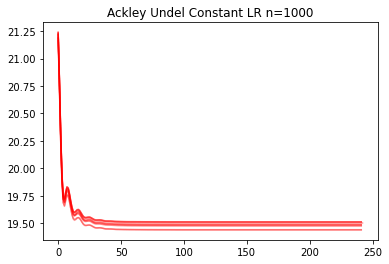

{'max_learning_rate': 3.2463610048983234, 'min_learning_rate': 0.44125507757078253, 'step_size': 660}


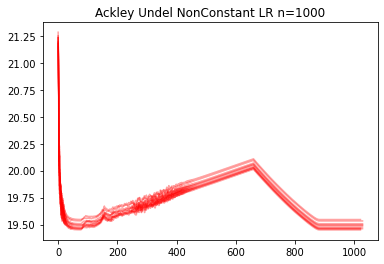

{'max_learning_rate': 3.7294646719844895, 'min_learning_rate': 0.7089373230629513, 'step_size': 980}


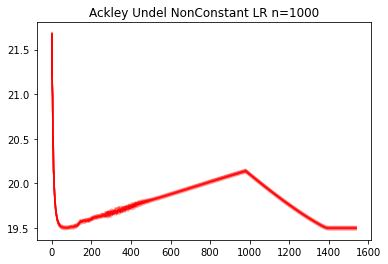

{'max_learning_rate': 3.804591285080024, 'min_learning_rate': 0.6929883959934303, 'step_size': 720}


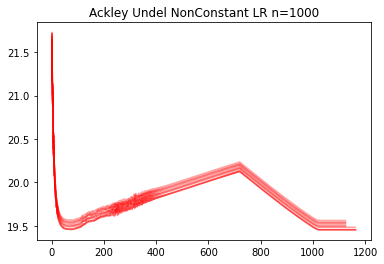

{'max_learning_rate': 3.490761243412859, 'min_learning_rate': 0.20682742648679334, 'step_size': 1750}


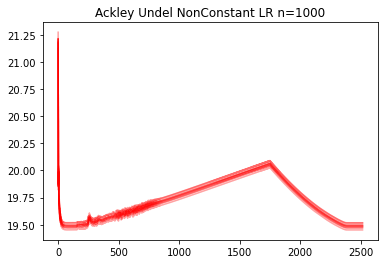

{'max_learning_rate': 3.992352869453829, 'min_learning_rate': 0.662149761383901, 'step_size': 360}


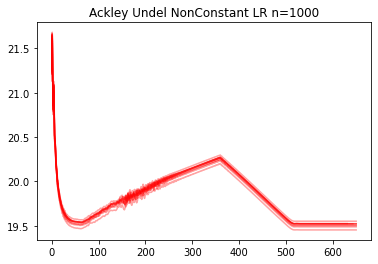

{'max_learning_rate': 1.666484918776795, 'min_learning_rate': 0.45981921131991793, 'step_size': 820}


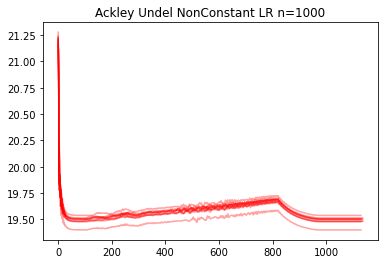

{'max_learning_rate': 3.5810386205852214, 'min_learning_rate': 0.6854664694659564, 'step_size': 480}


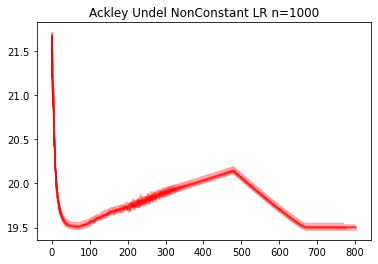

{'max_learning_rate': 3.926466281103339, 'min_learning_rate': 0.6090651243038723, 'step_size': 2050}


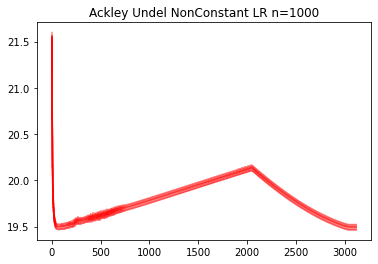

{'max_learning_rate': 2.6066773384951, 'min_learning_rate': 0.3053406801361801, 'step_size': 930}


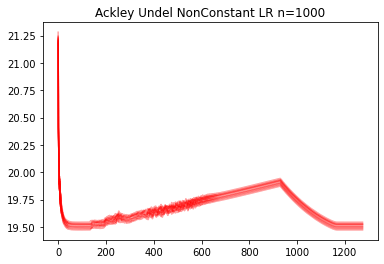

{'max_learning_rate': 2.7692229979077427, 'min_learning_rate': 0.6291242716372082, 'step_size': 1500}


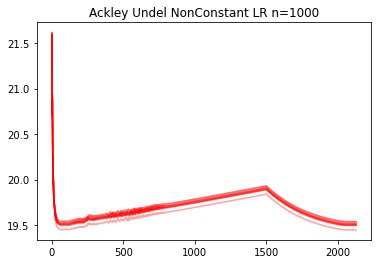

{'max_learning_rate': 1.3457519747555762, 'min_learning_rate': 0.6535906467995845, 'step_size': 210}


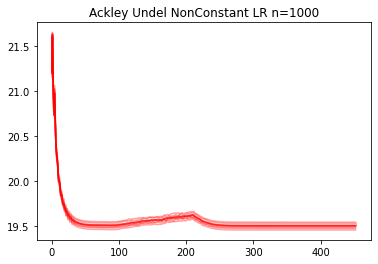

{'max_learning_rate': 1.4286210798754053, 'min_learning_rate': 0.877521913893367, 'step_size': 510}


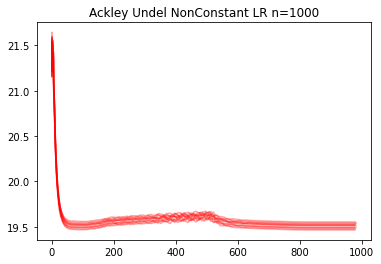

{'max_learning_rate': 2.178749474833508, 'min_learning_rate': 0.14668557981264777, 'step_size': 210}


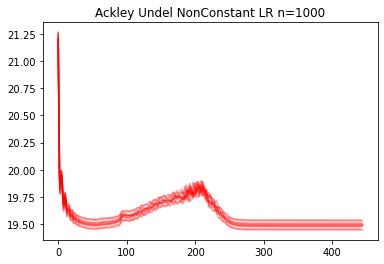

{'max_learning_rate': 2.5671576900296507, 'min_learning_rate': 0.5322145012487101, 'step_size': 1050}


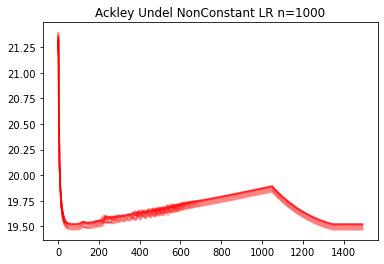

{'max_learning_rate': 4.7583443393046965, 'min_learning_rate': 0.119587944534201, 'step_size': 720}


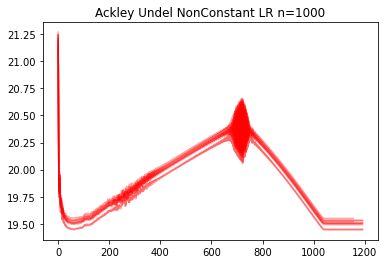

{'max_learning_rate': 3.42638541736293, 'min_learning_rate': 0.3978279277483261, 'step_size': 490}


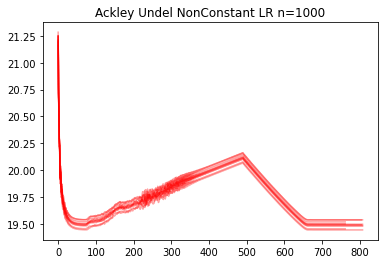

{'max_learning_rate': 4.2845010732680375, 'min_learning_rate': 0.40928007755480145, 'step_size': 2310}


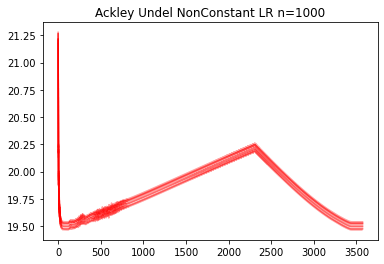

{'max_learning_rate': 3.716637744618431, 'min_learning_rate': 0.8633901030159038, 'step_size': 590}


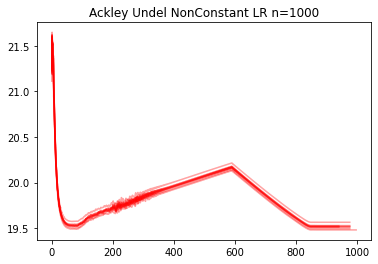

{'max_learning_rate': 2.359883594080602, 'min_learning_rate': 0.1031797344075776, 'step_size': 590}


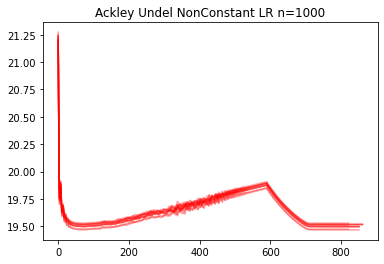

{'max_learning_rate': 2.42260786664032, 'min_learning_rate': 0.7414334782115147, 'step_size': 950}


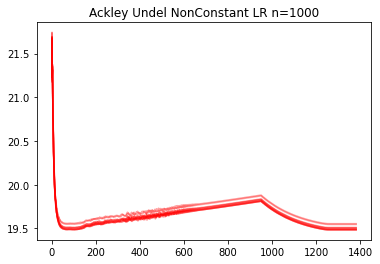

{'max_learning_rate': 3.7294646719844895, 'min_learning_rate': 0.7089373230629513, 'step_size': 980}


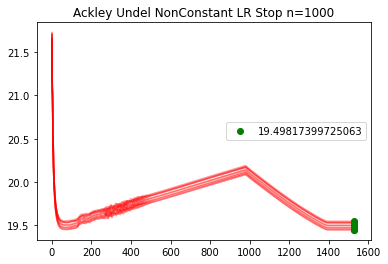

{'max_learning_rate': 3.804591285080024, 'min_learning_rate': 0.6929883959934303, 'step_size': 720}


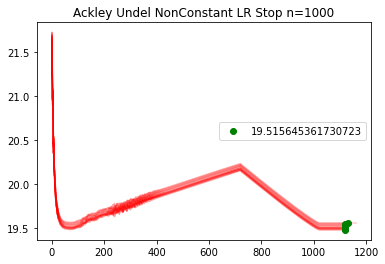

{'max_learning_rate': 3.992352869453829, 'min_learning_rate': 0.662149761383901, 'step_size': 360}


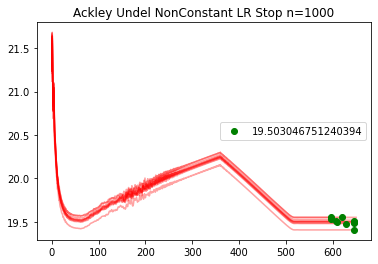

{'max_learning_rate': 3.5810386205852214, 'min_learning_rate': 0.6854664694659564, 'step_size': 480}


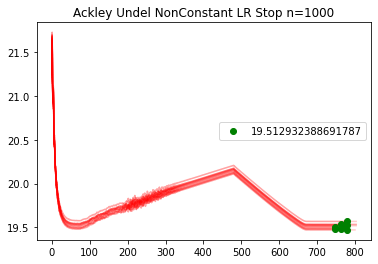

{'max_learning_rate': 2.6066773384951, 'min_learning_rate': 0.3053406801361801, 'step_size': 930}


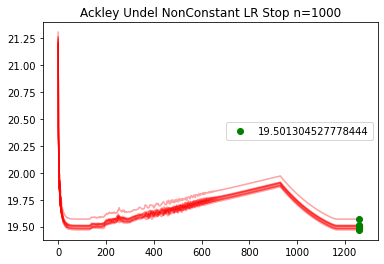

{'max_learning_rate': 1.3457519747555762, 'min_learning_rate': 0.6535906467995845, 'step_size': 210}


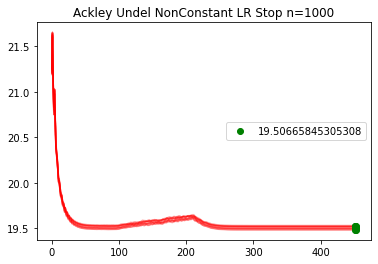

{'max_learning_rate': 4.7583443393046965, 'min_learning_rate': 0.119587944534201, 'step_size': 720}


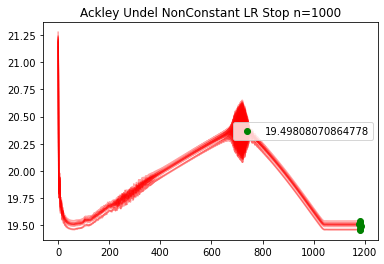

{'max_learning_rate': 3.42638541736293, 'min_learning_rate': 0.3978279277483261, 'step_size': 490}


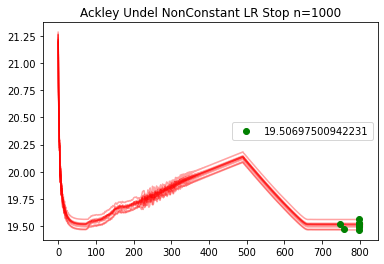

{'max_learning_rate': 3.716637744618431, 'min_learning_rate': 0.8633901030159038, 'step_size': 590}


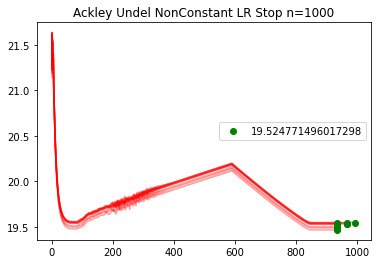

{'max_learning_rate': 2.359883594080602, 'min_learning_rate': 0.1031797344075776, 'step_size': 590}


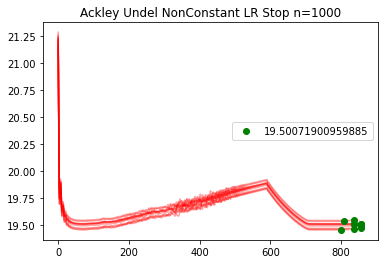

In [14]:
#symmetric with constant learning rate
analyzer(ack_undel, dom_range=[-32., 32.], Title="Ackley Undel Constant LR", symmetric_delays=False, use_delays=False, constant_learning_rate=True, dim=1000)
#symmetric nonconstant learning rate
analyzer(ack_undel_lr, dom_range=[-32., 32.], Title="Ackley Undel NonConstant LR", symmetric_delays=False, use_delays=False, constant_learning_rate=False, num_tests=10, dim=1000)
#symmertic non constant learning rate with early stopping 
analyzer(ack_undel_lr_stop, dom_range=[-32.,32.], Title="Ackley Undel NonConstant LR Stop", symmetric_delays=False, use_delays=False, constant_learning_rate=False, num_tests=10, dim=1000, early_stopping=True)

### 10000 Dimensional ackley tests

##### Symmetric Results

0.5870422785043486


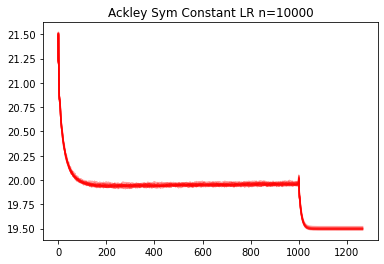

0.40555581877562663


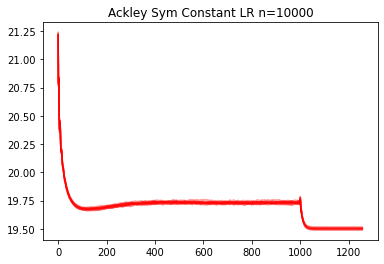

0.9038385037432809


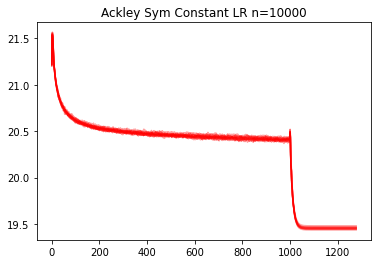

{'max_learning_rate': 3.4403467439840876, 'min_learning_rate': 0.24528954288219196, 'step_size': 650}


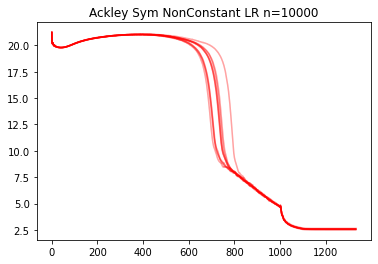

{'max_learning_rate': 1.9576068198056435, 'min_learning_rate': 0.6716984683843781, 'step_size': 210}


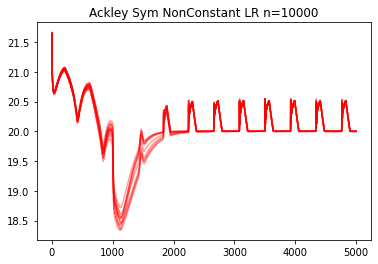

{'max_learning_rate': 2.978874359624832, 'min_learning_rate': 0.22903028290759941, 'step_size': 740}


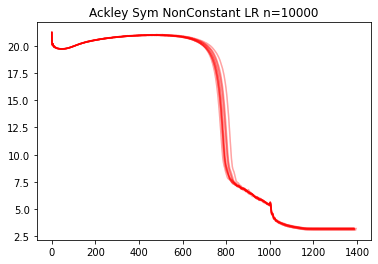

{'max_learning_rate': 4.920301036771987, 'min_learning_rate': 0.36818691628878186, 'step_size': 950}


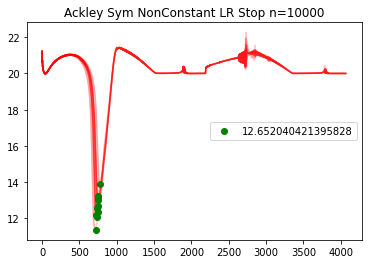

{'max_learning_rate': 2.2451583281241287, 'min_learning_rate': 0.8421939905693973, 'step_size': 530}


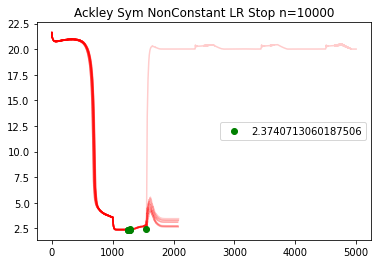

In [15]:
#symmetric with constant learning rate
analyzer(ack_del_sym, dom_range=[-32., 32.], Title="Ackley Sym Constant LR", constant_learning_rate=True, symmetric_delays=True, dim=10000)
#symmetric nonconstant learning rate
analyzer(ack_del_lr_sym, dom_range=[-32., 32.], Title="Ackley Sym NonConstant LR", constant_learning_rate=False, symmetric_delays=True, num_tests=10, dim=10000)
#symmertic non constant learning rate with early stopping 
analyzer(ack_del_lr_sym_stop, dom_range=[-32.,32.], Title="Ackley Sym NonConstant LR Stop", constant_learning_rate=False, symmetric_delays=True, num_tests=10, dim=10000, early_stopping=True)

#### Undelayed Results

0.7178773814803874


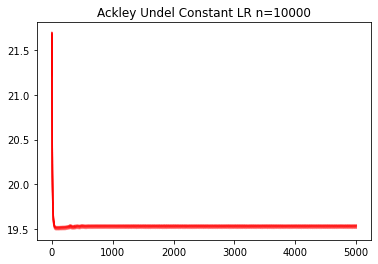

0.22656763651449902


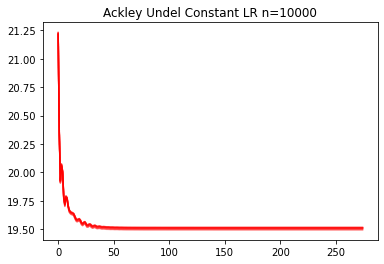

0.989107018776777


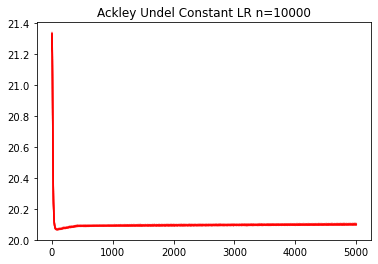

1.365481380277731


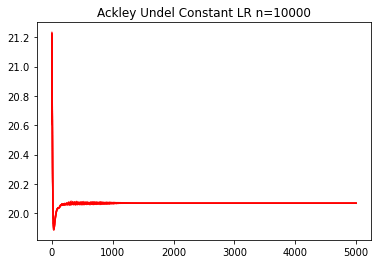

{'max_learning_rate': 2.999558367265194, 'min_learning_rate': 0.7486650077972461, 'step_size': 550}


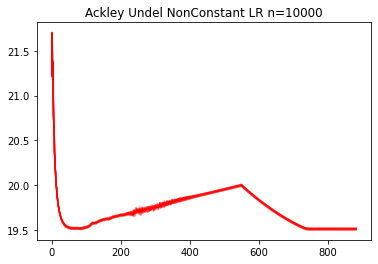

{'max_learning_rate': 2.4837227630769516, 'min_learning_rate': 0.628597293830526, 'step_size': 2320}


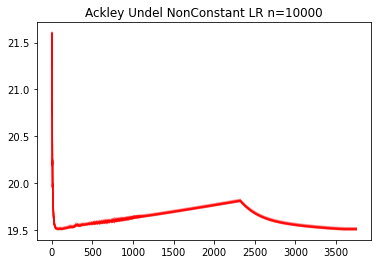

{'max_learning_rate': 3.6015323193817474, 'min_learning_rate': 0.410391917488078, 'step_size': 1250}


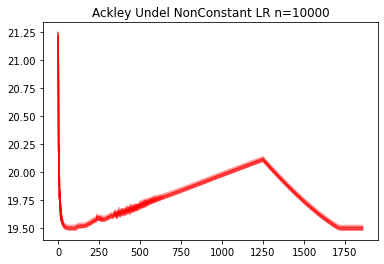

{'max_learning_rate': 2.965755334550514, 'min_learning_rate': 0.7021213180531974, 'step_size': 370}


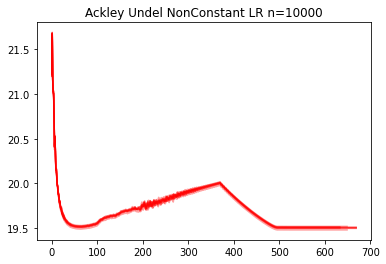

{'max_learning_rate': 2.2967038442936505, 'min_learning_rate': 0.5871089133932688, 'step_size': 450}


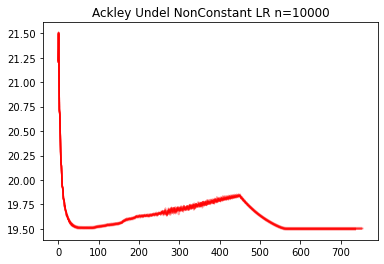

{'max_learning_rate': 3.6257313158687254, 'min_learning_rate': 0.8198148956867684, 'step_size': 920}


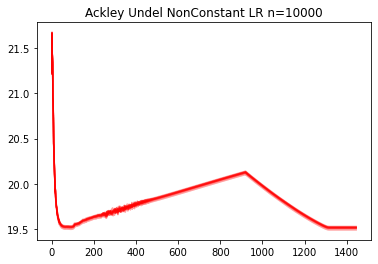

{'max_learning_rate': 3.3493804098493025, 'min_learning_rate': 0.3437232815638965, 'step_size': 2050}


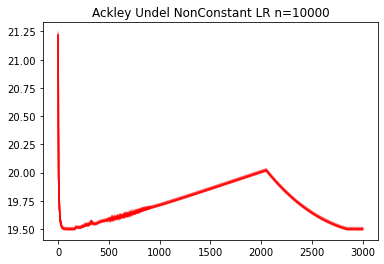

{'max_learning_rate': 2.4837227630769516, 'min_learning_rate': 0.628597293830526, 'step_size': 2320}


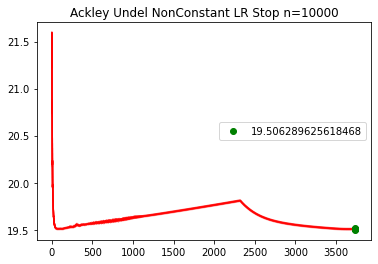

{'max_learning_rate': 2.2967038442936505, 'min_learning_rate': 0.5871089133932688, 'step_size': 450}


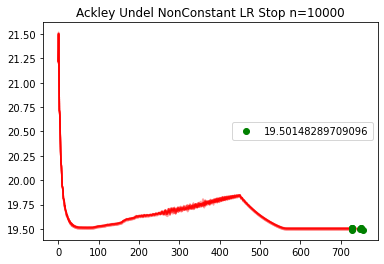

{'max_learning_rate': 3.3493804098493025, 'min_learning_rate': 0.3437232815638965, 'step_size': 2050}


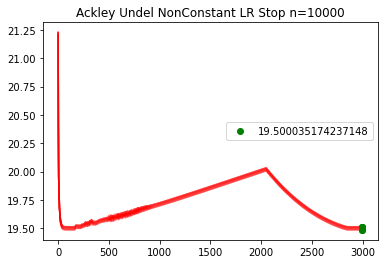

In [16]:
#symmetric with constant learning rate
analyzer(ack_undel, dom_range=[-32., 32.], Title="Ackley Undel Constant LR", symmetric_delays=False, use_delays=False, constant_learning_rate=True, dim=10000)
#symmetric nonconstant learning rate
analyzer(ack_undel_lr, dom_range=[-32., 32.], Title="Ackley Undel NonConstant LR", symmetric_delays=False, use_delays=False, constant_learning_rate=False, num_tests=10, dim=10000)
#symmertic non constant learning rate with early stopping 
analyzer(ack_undel_lr_stop, dom_range=[-32.,32.], Title="Ackley Undel NonConstant LR Stop", symmetric_delays=False, use_delays=False, constant_learning_rate=False, num_tests=10, dim=10000, early_stopping=True)

In [20]:
def select_object(dim, num, list_select):
    it_num = 1
    for i in list_select:
        if (i.n == dim):
            if (it_num == num):
                return i  
            it_num += 1

In [53]:
def plot_lists(object_list, ud_list, sym_del_list, clr_list, es_list, titles_list, num_tests=50, maxiter=5000, tol=1e-5, dom_range=[-32.,32.]):
    #helper function for analyzing results of a specific list
    it_num = 0
    colors_list = ['b','g','r','c','m','y','k','0.75','0.31']
    for it,i in enumerate(object_list):
        Title = titles_list[it]
        constant_learning_rate = clr_list[it]
        use_delays = ud_list[it]
        symmetric_delays = sym_del_list[it]
        early_stopping = es_list[it]
        print(i.Optimizer.learning_rate_bounds)
        if (constant_learning_rate is True):
            i.Optimizer.params['learning_rate'] = i.Optimizer.learning_rate_bounds * np.ones(maxiter)
        else:
            i.Optimizer.params['learning_rate'] = gen_learning_rates(i.Optimizer.learning_rate_bounds, maxiter)
        plt.clf()
        list_mins = list()
        list_argmins = list()
        for j in range(num_tests):
            i.x_init = np.random.uniform(dom_range[0],dom_range[1],i.n)
            i.delete_time_series()
            i.compute_time_series(use_delays=use_delays, maxiter=maxiter, tol=tol, symmetric_delays=symmetric_delays, random=True)
            x_vals = list()
            for k in range(len(i.time_series)):
                x_vals.append(i.loss_function(i.time_series[k,:]))
            i.delete_time_series()
            if (early_stopping is True):
                list_mins.append(np.min(x_vals))
                argmin = np.argmin(x_vals)
                list_argmins.append(argmin)
                ys = np.arange(0, argmin+1, 1)
                plt.plot(ys, x_vals[:argmin+1], color=colors_list[it], alpha=0.2)
            else:
                ys = np.arange(0, len(x_vals), 1)
                plt.plot(ys, x_vals, color=colors_list[it], alpha=0.2)
        if (early_stopping is True):  
            mean_min = np.mean(list_mins)
            plt.plot(list_argmins, list_mins, 'og', label = "{}".format(mean_min))
            plt.legend(loc="center right")
        plt.ylim([0,25])
        plt.title(Title+" n={}".format(i.n))
        plt.show()

## The "Best" Ackley Results Comparison

#### The "best" ones are chosen and then run with 50 different inital points randomly generated

1.3390967551601636


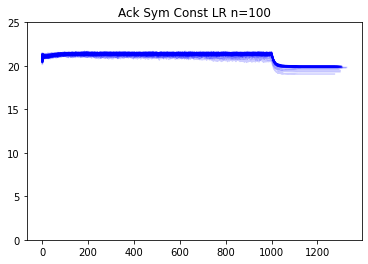

0.6093178028428891


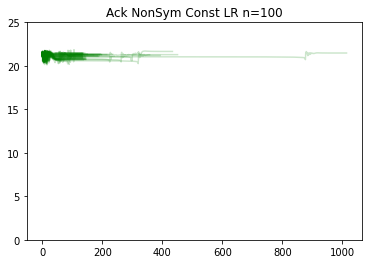

{'max_learning_rate': 2.2202182935831605, 'min_learning_rate': 0.9095628920469846, 'step_size': 600}


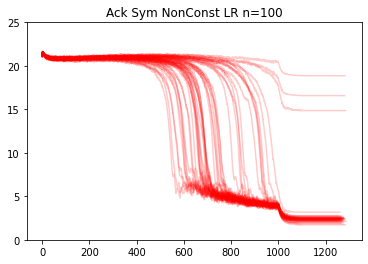

{'max_learning_rate': 2.358704471676799, 'min_learning_rate': 0.12919414280285516, 'step_size': 2460}


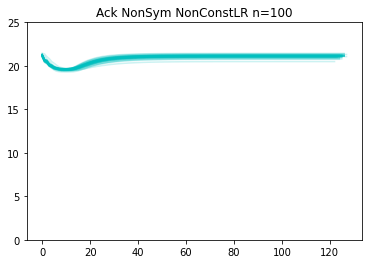

{'max_learning_rate': 2.5991657483884576, 'min_learning_rate': 0.2981984741646861, 'step_size': 860}


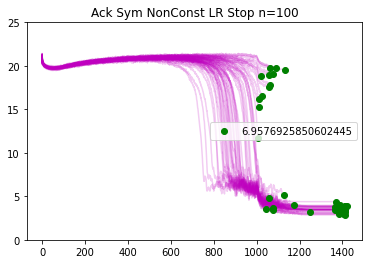

{'max_learning_rate': 1.4229203743264347, 'min_learning_rate': 0.16753070023245276, 'step_size': 260}


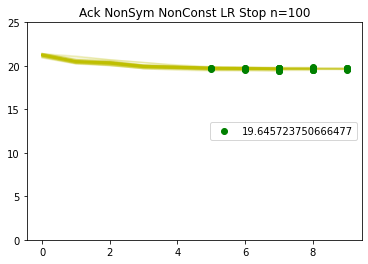

0.09327249304805008


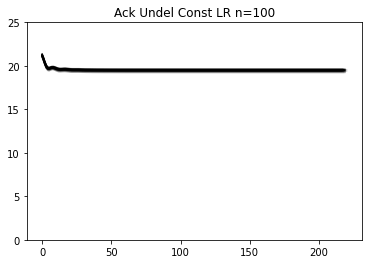

{'max_learning_rate': 1.6747270076938312, 'min_learning_rate': 0.6249791950444612, 'step_size': 310}


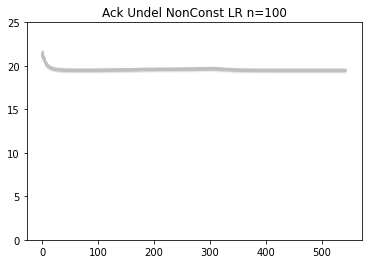

{'max_learning_rate': 2.9938985361306303, 'min_learning_rate': 0.2022298589892001, 'step_size': 2300}


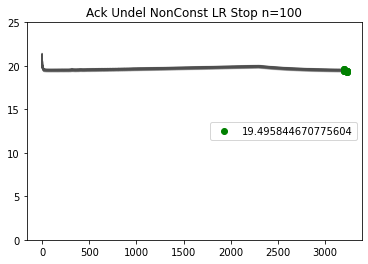

In [54]:
#100 Dimensions
#Ackley Nonconstant Symmetric LR : 7
#Ackley Constant Symmetric LR : 3 
#Ackley Constant NonSym LR: 5
#Ackley Nonconstant NonSymmetric LR : 8
#Ackley Nonsymmetric Early Stopping: 1
#Ackey Symmetric Early Stopping: 10
#Ackley Undelay Nonconstant LR: 4
#Ackley Undelay Constant LR: 1
#Ackley undelay early stopping: 9
#(use_delays, symmetric_delays, constant_learning_rate, early_stopping)
tuple_list = [(ack_del_sym,3,True,True,True,False),
              (ack_del_unsym,5,True,False,True,False),
              (ack_del_lr_sym,7,True,True,False,False),
              (ack_del_lr_nonsym,8,True,False,False,False),
              (ack_del_lr_sym_stop,10,True,True,False,True),
              (ack_del_lr_nonsym_stop,1,True,False,False,True),
              (ack_undel,1,False,True,True,False),
              (ack_undel_lr,4,False,True,False,False),
              (ack_undel_lr_stop,9,False,True,False,True)]
object_list = list()
use_delays_list = list()
symmetric_delays_list = list()
constant_learning_rate_list = list()
early_stopping_list = list()
titles_list = ["Ack Sym Const LR", "Ack NonSym Const LR", 
               "Ack Sym NonConst LR", "Ack NonSym NonConstLR",
               "Ack Sym NonConst LR Stop", "Ack NonSym NonConst LR Stop",
               "Ack Undel Const LR", "Ack Undel NonConst LR",
               "Ack Undel NonConst LR Stop"]
for list_test, num, use_delays, symmetric_delays, constant_learning_rate, early_stopping in tuple_list:
    use_delays_list.append(use_delays)
    symmetric_delays_list.append(symmetric_delays)
    constant_learning_rate_list.append(constant_learning_rate)
    early_stopping_list.append(early_stopping)
    object_insert = select_object(100,num,list_test)
    object_list.append(object_insert)
#now use the above function to plot results of 50 tests
plot_lists(object_list, use_delays_list, symmetric_delays_list,
           constant_learning_rate_list, early_stopping_list, titles_list=titles_list)

0.7799405609742002


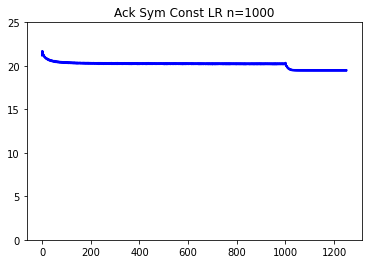

{'max_learning_rate': 2.102161251175967, 'min_learning_rate': 0.7567330639801254, 'step_size': 320}


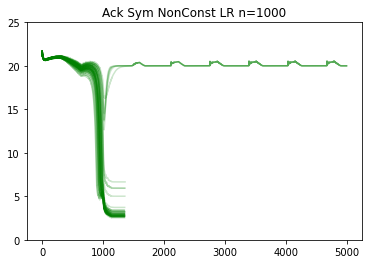

{'max_learning_rate': 2.8687478384155707, 'min_learning_rate': 0.3800881136545512, 'step_size': 960}


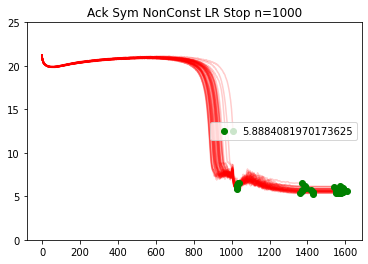

1.0066023557560235


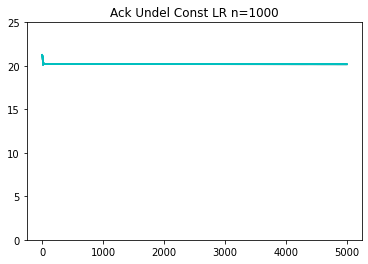

{'max_learning_rate': 3.804591285080024, 'min_learning_rate': 0.6929883959934303, 'step_size': 720}


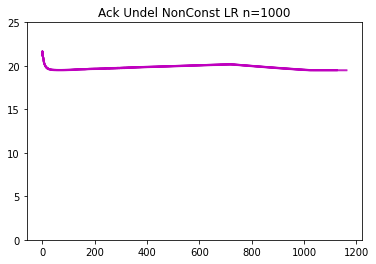

{'max_learning_rate': 3.5810386205852214, 'min_learning_rate': 0.6854664694659564, 'step_size': 480}


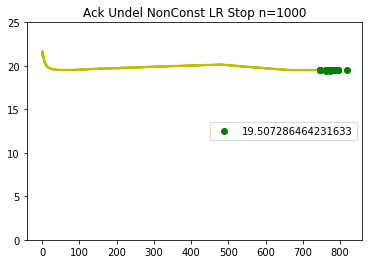

In [55]:
#1000 Dimensions
#Ackley Nonconstant Symmetric LR : 2
#Ackley Constant Symmetric LR : 2 
#Ackey Symmetric Early Stopping: 2
#Ackley Undelay Nonconstant LR: 3
#Ackley Undelay Constant LR: 1
#Ackley undelay early stopping: 4 

tuple_list = [(ack_del_sym,2,True,True,True,False),
              (ack_del_lr_sym,2,True,True,False,False),
              (ack_del_lr_sym_stop,2,True,True,False,True),
              (ack_undel,1,False,True,True,False),
              (ack_undel_lr,3,False,True,False,False),
              (ack_undel_lr_stop,4,False,True,False,True)]
object_list = list()
use_delays_list = list()
symmetric_delays_list = list()
constant_learning_rate_list = list()
early_stopping_list = list()
titles_list = ["Ack Sym Const LR", 
               "Ack Sym NonConst LR",
               "Ack Sym NonConst LR Stop",
               "Ack Undel Const LR", "Ack Undel NonConst LR",
               "Ack Undel NonConst LR Stop"]
for list_test, num, use_delays, symmetric_delays, constant_learning_rate, early_stopping in tuple_list:
    use_delays_list.append(use_delays)
    symmetric_delays_list.append(symmetric_delays)
    constant_learning_rate_list.append(constant_learning_rate)
    early_stopping_list.append(early_stopping)
    object_insert = select_object(1000,num,list_test)
    object_list.append(object_insert)
#now use the above function to plot results of 50 tests
plot_lists(object_list, use_delays_list, symmetric_delays_list,
           constant_learning_rate_list, early_stopping_list, titles_list=titles_list)

0.40555581877562663


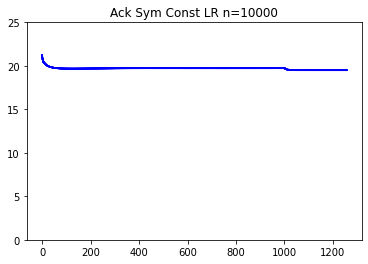

{'max_learning_rate': 2.978874359624832, 'min_learning_rate': 0.22903028290759941, 'step_size': 740}


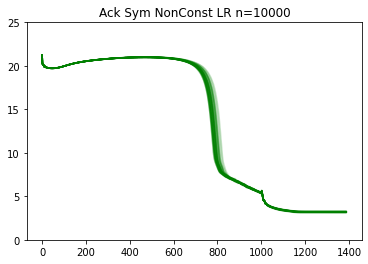

{'max_learning_rate': 2.2451583281241287, 'min_learning_rate': 0.8421939905693973, 'step_size': 530}


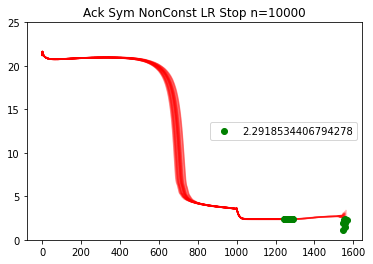

0.22656763651449902


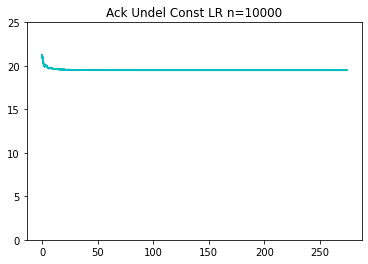

{'max_learning_rate': 2.999558367265194, 'min_learning_rate': 0.7486650077972461, 'step_size': 550}


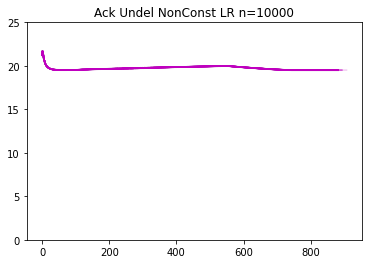

{'max_learning_rate': 2.4837227630769516, 'min_learning_rate': 0.628597293830526, 'step_size': 2320}


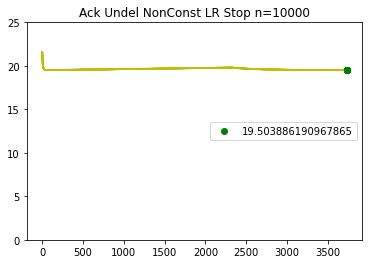

In [56]:
#10000 Dimensions
#Ackley Nonconstant Symmetric LR : 3
#Ackley Constant Symmetric LR : 2 
#Ackey Symmetric Early Stopping: 2
#Ackley Undelay Nonconstant LR: 1
#Ackley Undelay Constant LR: 2
#Ackley undelay early stopping: 1 
tuple_list = [(ack_del_sym,2,True,True,True,False),
              (ack_del_lr_sym,3,True,True,False,False),
              (ack_del_lr_sym_stop,2,True,True,False,True),
              (ack_undel,2,False,True,True,False),
              (ack_undel_lr,1,False,True,False,False),
              (ack_undel_lr_stop,1,False,True,False,True)]
object_list = list()
use_delays_list = list()
symmetric_delays_list = list()
constant_learning_rate_list = list()
early_stopping_list = list()
titles_list = ["Ack Sym Const LR", 
               "Ack Sym NonConst LR",
               "Ack Sym NonConst LR Stop",
               "Ack Undel Const LR", "Ack Undel NonConst LR",
               "Ack Undel NonConst LR Stop"]
for list_test, num, use_delays, symmetric_delays, constant_learning_rate, early_stopping in tuple_list:
    use_delays_list.append(use_delays)
    symmetric_delays_list.append(symmetric_delays)
    constant_learning_rate_list.append(constant_learning_rate)
    early_stopping_list.append(early_stopping)
    object_insert = select_object(10000,num,list_test)
    object_list.append(object_insert)
#now use the above function to plot results of 50 tests
plot_lists(object_list, use_delays_list, symmetric_delays_list,
           constant_learning_rate_list, early_stopping_list, titles_list=titles_list)